In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

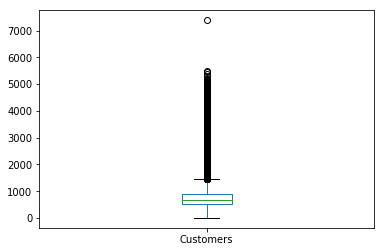

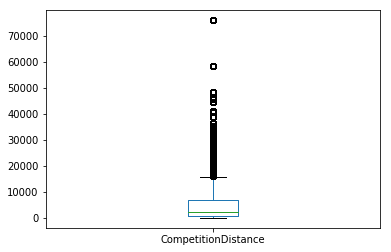

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

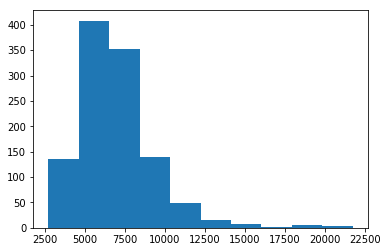

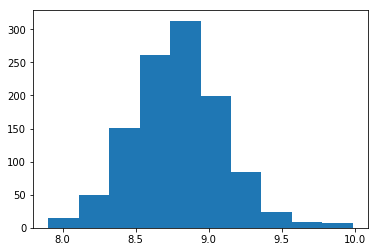

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    print(data['Year'].dtype)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
int64
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


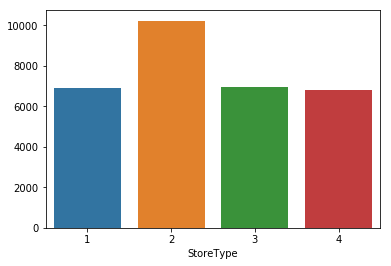

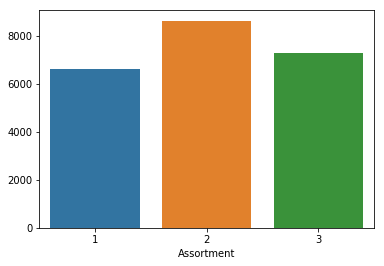

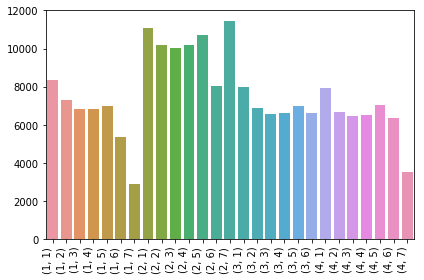

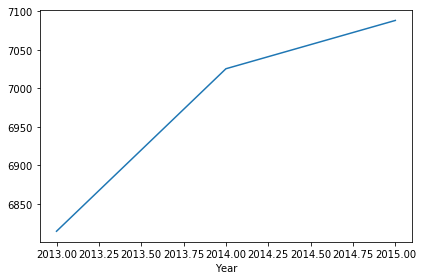

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 16)
(10133, 16)


D:\AnaconDA\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


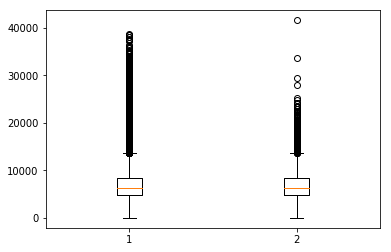

In [14]:
plt.boxplot([Y_train,Y_valid])
plt.show()

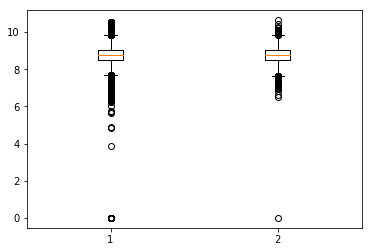

In [15]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [16]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [17]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 12,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 1000

# dtrain = xgb.DMatrix(X_train, Y_train)
# dvalid = xgb.DMatrix(X_valid, Y_valid)
# dtest = xgb.DMatrix(test)
eval_set= [(X_train, Y_train),(X_valid, Y_valid)]
#watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=num_trees,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:7.44317	validation_1-rmse:7.43873	validation_0-rmspe:0.999496	validation_1-rmspe:0.999477
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70068	validation_1-rmse:6.69677	validation_0-rmspe:0.998793	validation_1-rmspe:0.998771
[2]	validation_0-rmse:6.03251	validation_1-rmse:6.02901	validation_0-rmspe:0.997524	validation_1-rmspe:0.997498
[3]	validation_0-rmse:5.43118	validation_1-rmse:5.42795	validation_0-rmspe:0.99539	validation_1-rmspe:0.99536
[4]	validation_0-rmse:4.89003	validation_1-rmse:4.88712	validation_0-rmspe:0.99202	validation_1-rmspe:0.991984
[5]	validation_0-rmse:4.40306	validation_1-rmse:4.40039	validation_0-rmspe:0.986986	validation_1-rmspe:0.986942
[6]	validation_0-rmse:3.96507	validation_1-rmse:3.96277	validation_0-rmspe:0.979815	validation_1-rmspe:0.979764
[7]	validation_0-rmse:3.57084	validation_1-rmse:3.56869	va

[71]	validation_0-rmse:0.160647	validation_1-rmse:0.174181	validation_0-rmspe:0.196863	validation_1-rmspe:0.161892
[72]	validation_0-rmse:0.160275	validation_1-rmse:0.17384	validation_0-rmspe:0.196565	validation_1-rmspe:0.161605
[73]	validation_0-rmse:0.159788	validation_1-rmse:0.173575	validation_0-rmspe:0.196263	validation_1-rmspe:0.161416
[74]	validation_0-rmse:0.159538	validation_1-rmse:0.173343	validation_0-rmspe:0.196107	validation_1-rmspe:0.161217
[75]	validation_0-rmse:0.158533	validation_1-rmse:0.172468	validation_0-rmspe:0.19533	validation_1-rmspe:0.160309
[76]	validation_0-rmse:0.15641	validation_1-rmse:0.170589	validation_0-rmspe:0.193435	validation_1-rmspe:0.158296
[77]	validation_0-rmse:0.155816	validation_1-rmse:0.170088	validation_0-rmspe:0.192655	validation_1-rmspe:0.157722
[78]	validation_0-rmse:0.155612	validation_1-rmse:0.169916	validation_0-rmspe:0.192748	validation_1-rmspe:0.157572
[79]	validation_0-rmse:0.155105	validation_1-rmse:0.169386	validation_0-rmspe:0.192

[143]	validation_0-rmse:0.117504	validation_1-rmse:0.142439	validation_0-rmspe:0.135417	validation_1-rmspe:0.124681
[144]	validation_0-rmse:0.117193	validation_1-rmse:0.142316	validation_0-rmspe:0.135157	validation_1-rmspe:0.124529
[145]	validation_0-rmse:0.116586	validation_1-rmse:0.141903	validation_0-rmspe:0.134657	validation_1-rmspe:0.12406
[146]	validation_0-rmse:0.116281	validation_1-rmse:0.141728	validation_0-rmspe:0.134429	validation_1-rmspe:0.123815
[147]	validation_0-rmse:0.115944	validation_1-rmse:0.14148	validation_0-rmspe:0.134101	validation_1-rmspe:0.12351
[148]	validation_0-rmse:0.115712	validation_1-rmse:0.141379	validation_0-rmspe:0.133915	validation_1-rmspe:0.123401
[149]	validation_0-rmse:0.115453	validation_1-rmse:0.141215	validation_0-rmspe:0.133646	validation_1-rmspe:0.123187
[150]	validation_0-rmse:0.115134	validation_1-rmse:0.140984	validation_0-rmspe:0.133444	validation_1-rmspe:0.122985
[151]	validation_0-rmse:0.11494	validation_1-rmse:0.14089	validation_0-rmsp

[214]	validation_0-rmse:0.101289	validation_1-rmse:0.134425	validation_0-rmspe:0.112569	validation_1-rmspe:0.115824
[215]	validation_0-rmse:0.101038	validation_1-rmse:0.134363	validation_0-rmspe:0.112423	validation_1-rmspe:0.115742
[216]	validation_0-rmse:0.100863	validation_1-rmse:0.134284	validation_0-rmspe:0.112239	validation_1-rmspe:0.115466
[217]	validation_0-rmse:0.100568	validation_1-rmse:0.134246	validation_0-rmspe:0.11205	validation_1-rmspe:0.11541
[218]	validation_0-rmse:0.100394	validation_1-rmse:0.134163	validation_0-rmspe:0.111899	validation_1-rmspe:0.115276
[219]	validation_0-rmse:0.100281	validation_1-rmse:0.134117	validation_0-rmspe:0.111798	validation_1-rmspe:0.11523
[220]	validation_0-rmse:0.100243	validation_1-rmse:0.1341	validation_0-rmspe:0.111769	validation_1-rmspe:0.115245
[221]	validation_0-rmse:0.100125	validation_1-rmse:0.134041	validation_0-rmspe:0.111647	validation_1-rmspe:0.115168
[222]	validation_0-rmse:0.099928	validation_1-rmse:0.133949	validation_0-rmsp

[285]	validation_0-rmse:0.090888	validation_1-rmse:0.131521	validation_0-rmspe:0.096991	validation_1-rmspe:0.111398
[286]	validation_0-rmse:0.09065	validation_1-rmse:0.131477	validation_0-rmspe:0.096619	validation_1-rmspe:0.111328
[287]	validation_0-rmse:0.090534	validation_1-rmse:0.13145	validation_0-rmspe:0.096523	validation_1-rmspe:0.111292
[288]	validation_0-rmse:0.090327	validation_1-rmse:0.131426	validation_0-rmspe:0.096372	validation_1-rmspe:0.111244
[289]	validation_0-rmse:0.090257	validation_1-rmse:0.131381	validation_0-rmspe:0.096313	validation_1-rmspe:0.111191
[290]	validation_0-rmse:0.090036	validation_1-rmse:0.131298	validation_0-rmspe:0.095084	validation_1-rmspe:0.110922
[291]	validation_0-rmse:0.089894	validation_1-rmse:0.131251	validation_0-rmspe:0.09498	validation_1-rmspe:0.110869
[292]	validation_0-rmse:0.089753	validation_1-rmse:0.131217	validation_0-rmspe:0.094893	validation_1-rmspe:0.110858
[293]	validation_0-rmse:0.089677	validation_1-rmse:0.131157	validation_0-rm

[356]	validation_0-rmse:0.083428	validation_1-rmse:0.130114	validation_0-rmspe:0.085687	validation_1-rmspe:0.108887
[357]	validation_0-rmse:0.083362	validation_1-rmse:0.130104	validation_0-rmspe:0.085588	validation_1-rmspe:0.108877
[358]	validation_0-rmse:0.083294	validation_1-rmse:0.130132	validation_0-rmspe:0.085524	validation_1-rmspe:0.108922
[359]	validation_0-rmse:0.083227	validation_1-rmse:0.130104	validation_0-rmspe:0.085394	validation_1-rmspe:0.108902
[360]	validation_0-rmse:0.083165	validation_1-rmse:0.130103	validation_0-rmspe:0.08533	validation_1-rmspe:0.108889
[361]	validation_0-rmse:0.083074	validation_1-rmse:0.130119	validation_0-rmspe:0.08526	validation_1-rmspe:0.10883
[362]	validation_0-rmse:0.082994	validation_1-rmse:0.130114	validation_0-rmspe:0.085091	validation_1-rmspe:0.108821
[363]	validation_0-rmse:0.082839	validation_1-rmse:0.130134	validation_0-rmspe:0.085002	validation_1-rmspe:0.108855
[364]	validation_0-rmse:0.082728	validation_1-rmse:0.130103	validation_0-rm

[427]	validation_0-rmse:0.077641	validation_1-rmse:0.129618	validation_0-rmspe:0.079764	validation_1-rmspe:0.107627
[428]	validation_0-rmse:0.077587	validation_1-rmse:0.129628	validation_0-rmspe:0.079722	validation_1-rmspe:0.107655
[429]	validation_0-rmse:0.077546	validation_1-rmse:0.129598	validation_0-rmspe:0.079702	validation_1-rmspe:0.107669
[430]	validation_0-rmse:0.077483	validation_1-rmse:0.129589	validation_0-rmspe:0.079629	validation_1-rmspe:0.107661
[431]	validation_0-rmse:0.077438	validation_1-rmse:0.129593	validation_0-rmspe:0.079559	validation_1-rmspe:0.107571
[432]	validation_0-rmse:0.077372	validation_1-rmse:0.129576	validation_0-rmspe:0.079482	validation_1-rmspe:0.107576
[433]	validation_0-rmse:0.077328	validation_1-rmse:0.129561	validation_0-rmspe:0.079435	validation_1-rmspe:0.107564
[434]	validation_0-rmse:0.077251	validation_1-rmse:0.129525	validation_0-rmspe:0.079396	validation_1-rmspe:0.107486
[435]	validation_0-rmse:0.077218	validation_1-rmse:0.129527	validation_0

[498]	validation_0-rmse:0.073234	validation_1-rmse:0.129268	validation_0-rmspe:0.074881	validation_1-rmspe:0.106554
[499]	validation_0-rmse:0.073165	validation_1-rmse:0.129251	validation_0-rmspe:0.074831	validation_1-rmspe:0.106545
[500]	validation_0-rmse:0.073116	validation_1-rmse:0.129235	validation_0-rmspe:0.074788	validation_1-rmspe:0.106517
[501]	validation_0-rmse:0.073064	validation_1-rmse:0.129227	validation_0-rmspe:0.074757	validation_1-rmspe:0.106489
[502]	validation_0-rmse:0.073033	validation_1-rmse:0.129249	validation_0-rmspe:0.07457	validation_1-rmspe:0.106535
[503]	validation_0-rmse:0.072979	validation_1-rmse:0.129247	validation_0-rmspe:0.074501	validation_1-rmspe:0.106505
[504]	validation_0-rmse:0.07294	validation_1-rmse:0.129248	validation_0-rmspe:0.074448	validation_1-rmspe:0.106505
[505]	validation_0-rmse:0.072907	validation_1-rmse:0.129262	validation_0-rmspe:0.074414	validation_1-rmspe:0.10651
[506]	validation_0-rmse:0.072839	validation_1-rmse:0.129261	validation_0-rm

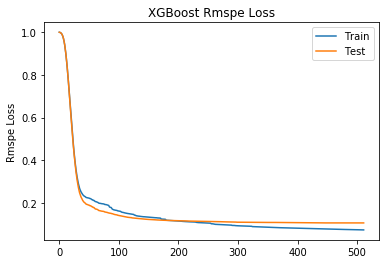

In [18]:
from matplotlib import pyplot
results = estimator.evals_result()
epochs = len(results['validation_0']['rmspe'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmspe'], label='Train')
ax.plot(x_axis, results['validation_1']['rmspe'], label='Test')
ax.legend()
pyplot.ylabel('Rmspe Loss')
pyplot.title('XGBoost Rmspe Loss')
pyplot.show()

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def customer_rmspe_xg(yhat, y):
    # y = y.values
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

param_test1 = {
 'max_depth':range(10,13,1),
 #'subsample': [0.7,0.8,0.9],
 #'learning_rate': [0.08,0.1,0.11]
}
params_fit = {
    'eval_metric':rmspe_xg,
    'early_stopping_rounds':20,
    'eval_set':eval_set
}
nums_round = 492
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch1.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=10 ....................................................
[0]	validation_0-rmse:7.44331	validation_1-rmse:7.43885	validation_0-rmspe:0.999495	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.7008	validation_1-rmse:6.69681	validation_0-rmspe:0.998792	validation_1-rmspe:0.99877
[2]	validation_0-rmse:6.03262	validation_1-rmse:6.02907	validation_0-rmspe:0.997522	validation_1-rmspe:0.997496
[3]	validation_0-rmse:5.43166	validation_1-rmse:5.42834	validation_0-rmspe:0.995378	validation_1-rmspe:0.995347
[4]	validation_0-rmse:4.89079	validation_1-rmse:4.88767	validation_0-rmspe:0.991988	validation_1-rmspe:0.99195
[5]	validation_0-rmse:4.40412	validation_1-rmse:4.40145	validation_0-rmspe:0.986919	validation_1-rmspe:0.986876
[6]	validation_0-rmse:3.96621	validation

[70]	validation_0-rmse:0.200148	validation_1-rmse:0.206115	validation_0-rmspe:0.242456	validation_1-rmspe:0.199955
[71]	validation_0-rmse:0.198291	validation_1-rmse:0.204418	validation_0-rmspe:0.240386	validation_1-rmspe:0.197903
[72]	validation_0-rmse:0.197446	validation_1-rmse:0.203675	validation_0-rmspe:0.239995	validation_1-rmspe:0.197184
[73]	validation_0-rmse:0.196786	validation_1-rmse:0.203074	validation_0-rmspe:0.239469	validation_1-rmspe:0.196602
[74]	validation_0-rmse:0.196337	validation_1-rmse:0.202691	validation_0-rmspe:0.239026	validation_1-rmspe:0.196206
[75]	validation_0-rmse:0.194543	validation_1-rmse:0.200987	validation_0-rmspe:0.237088	validation_1-rmspe:0.194318
[76]	validation_0-rmse:0.192668	validation_1-rmse:0.199356	validation_0-rmspe:0.235444	validation_1-rmspe:0.192541
[77]	validation_0-rmse:0.191902	validation_1-rmse:0.198587	validation_0-rmspe:0.234686	validation_1-rmspe:0.19162
[78]	validation_0-rmse:0.190091	validation_1-rmse:0.196844	validation_0-rmspe:0.2

[142]	validation_0-rmse:0.149375	validation_1-rmse:0.160709	validation_0-rmspe:0.195329	validation_1-rmspe:0.146511
[143]	validation_0-rmse:0.149076	validation_1-rmse:0.160475	validation_0-rmspe:0.194898	validation_1-rmspe:0.146239
[144]	validation_0-rmse:0.14884	validation_1-rmse:0.160272	validation_0-rmspe:0.194596	validation_1-rmspe:0.145983
[145]	validation_0-rmse:0.1482	validation_1-rmse:0.159672	validation_0-rmspe:0.194096	validation_1-rmspe:0.145346
[146]	validation_0-rmse:0.147559	validation_1-rmse:0.159118	validation_0-rmspe:0.193516	validation_1-rmspe:0.144684
[147]	validation_0-rmse:0.147014	validation_1-rmse:0.158693	validation_0-rmspe:0.193076	validation_1-rmspe:0.14418
[148]	validation_0-rmse:0.146434	validation_1-rmse:0.158217	validation_0-rmspe:0.192566	validation_1-rmspe:0.143572
[149]	validation_0-rmse:0.145956	validation_1-rmse:0.157741	validation_0-rmspe:0.192151	validation_1-rmspe:0.142977
[150]	validation_0-rmse:0.145168	validation_1-rmse:0.156986	validation_0-rms

[213]	validation_0-rmse:0.127965	validation_1-rmse:0.143715	validation_0-rmspe:0.177652	validation_1-rmspe:0.126253
[214]	validation_0-rmse:0.127818	validation_1-rmse:0.143619	validation_0-rmspe:0.177484	validation_1-rmspe:0.126105
[215]	validation_0-rmse:0.127595	validation_1-rmse:0.143414	validation_0-rmspe:0.177312	validation_1-rmspe:0.125831
[216]	validation_0-rmse:0.127453	validation_1-rmse:0.143335	validation_0-rmspe:0.17715	validation_1-rmspe:0.125732
[217]	validation_0-rmse:0.127256	validation_1-rmse:0.143193	validation_0-rmspe:0.176986	validation_1-rmspe:0.125569
[218]	validation_0-rmse:0.127101	validation_1-rmse:0.143081	validation_0-rmspe:0.176749	validation_1-rmspe:0.125429
[219]	validation_0-rmse:0.126997	validation_1-rmse:0.143	validation_0-rmspe:0.17666	validation_1-rmspe:0.125345
[220]	validation_0-rmse:0.12686	validation_1-rmse:0.142994	validation_0-rmspe:0.176516	validation_1-rmspe:0.125304
[221]	validation_0-rmse:0.126633	validation_1-rmse:0.142801	validation_0-rmspe

[284]	validation_0-rmse:0.118766	validation_1-rmse:0.13753	validation_0-rmspe:0.166348	validation_1-rmspe:0.118405
[285]	validation_0-rmse:0.118609	validation_1-rmse:0.137406	validation_0-rmspe:0.166233	validation_1-rmspe:0.118247
[286]	validation_0-rmse:0.118462	validation_1-rmse:0.137336	validation_0-rmspe:0.16592	validation_1-rmspe:0.118145
[287]	validation_0-rmse:0.118211	validation_1-rmse:0.137181	validation_0-rmspe:0.165702	validation_1-rmspe:0.117935
[288]	validation_0-rmse:0.118109	validation_1-rmse:0.137141	validation_0-rmspe:0.165602	validation_1-rmspe:0.117877
[289]	validation_0-rmse:0.118051	validation_1-rmse:0.137123	validation_0-rmspe:0.165546	validation_1-rmspe:0.117858
[290]	validation_0-rmse:0.11798	validation_1-rmse:0.137072	validation_0-rmspe:0.165464	validation_1-rmspe:0.11779
[291]	validation_0-rmse:0.117861	validation_1-rmse:0.13702	validation_0-rmspe:0.165392	validation_1-rmspe:0.117724
[292]	validation_0-rmse:0.117777	validation_1-rmse:0.136964	validation_0-rmsp

[355]	validation_0-rmse:0.113071	validation_1-rmse:0.134709	validation_0-rmspe:0.157371	validation_1-rmspe:0.114375
[356]	validation_0-rmse:0.113037	validation_1-rmse:0.134679	validation_0-rmspe:0.157206	validation_1-rmspe:0.114329
[357]	validation_0-rmse:0.112965	validation_1-rmse:0.13464	validation_0-rmspe:0.157146	validation_1-rmspe:0.114261
[358]	validation_0-rmse:0.112878	validation_1-rmse:0.134583	validation_0-rmspe:0.157098	validation_1-rmspe:0.114188
[359]	validation_0-rmse:0.112775	validation_1-rmse:0.134547	validation_0-rmspe:0.156998	validation_1-rmspe:0.114144
[360]	validation_0-rmse:0.11272	validation_1-rmse:0.13451	validation_0-rmspe:0.156966	validation_1-rmspe:0.114134
[361]	validation_0-rmse:0.112601	validation_1-rmse:0.134494	validation_0-rmspe:0.156881	validation_1-rmspe:0.114102
[362]	validation_0-rmse:0.112528	validation_1-rmse:0.134449	validation_0-rmspe:0.156798	validation_1-rmspe:0.114028
[363]	validation_0-rmse:0.11246	validation_1-rmse:0.134422	validation_0-rms

[427]	validation_0-rmse:0.108944	validation_1-rmse:0.133347	validation_0-rmspe:0.154022	validation_1-rmspe:0.112345
[428]	validation_0-rmse:0.108919	validation_1-rmse:0.133335	validation_0-rmspe:0.154003	validation_1-rmspe:0.112326
[429]	validation_0-rmse:0.108866	validation_1-rmse:0.133327	validation_0-rmspe:0.154006	validation_1-rmspe:0.112315
[430]	validation_0-rmse:0.108817	validation_1-rmse:0.133305	validation_0-rmspe:0.154015	validation_1-rmspe:0.112292
[431]	validation_0-rmse:0.108751	validation_1-rmse:0.133265	validation_0-rmspe:0.153964	validation_1-rmspe:0.11224
[432]	validation_0-rmse:0.108711	validation_1-rmse:0.133276	validation_0-rmspe:0.15394	validation_1-rmspe:0.112224
[433]	validation_0-rmse:0.108642	validation_1-rmse:0.133253	validation_0-rmspe:0.153875	validation_1-rmspe:0.112202
[434]	validation_0-rmse:0.108623	validation_1-rmse:0.133242	validation_0-rmspe:0.153939	validation_1-rmspe:0.112179
[435]	validation_0-rmse:0.108574	validation_1-rmse:0.133226	validation_0-r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s


[0]	validation_0-rmse:7.4436	validation_1-rmse:7.43907	validation_0-rmspe:0.999494	validation_1-rmspe:0.999474
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70106	validation_1-rmse:6.69692	validation_0-rmspe:0.998789	validation_1-rmspe:0.998766
[2]	validation_0-rmse:6.03301	validation_1-rmse:6.02939	validation_0-rmspe:0.997513	validation_1-rmspe:0.997487
[3]	validation_0-rmse:5.43173	validation_1-rmse:5.42849	validation_0-rmspe:0.99537	validation_1-rmspe:0.995339
[4]	validation_0-rmse:4.89077	validation_1-rmse:4.88788	validation_0-rmspe:0.99198	validation_1-rmspe:0.991944
[5]	validation_0-rmse:4.40403	validation_1-rmse:4.40158	validation_0-rmspe:0.98691	validation_1-rmspe:0.986873
[6]	validation_0-rmse:3.9663	validation_1-rmse:3.96415	validation_0-rmspe:0.979694	validation_1-rmspe:0.979651
[7]	validation_0-rmse:3.57241	validation_1-rmse:3.57061	vali

[71]	validation_0-rmse:0.19528	validation_1-rmse:0.201332	validation_0-rmspe:0.235002	validation_1-rmspe:0.194619
[72]	validation_0-rmse:0.19371	validation_1-rmse:0.199867	validation_0-rmspe:0.233505	validation_1-rmspe:0.193098
[73]	validation_0-rmse:0.193139	validation_1-rmse:0.199361	validation_0-rmspe:0.232615	validation_1-rmspe:0.19263
[74]	validation_0-rmse:0.192587	validation_1-rmse:0.198872	validation_0-rmspe:0.232036	validation_1-rmspe:0.192137
[75]	validation_0-rmse:0.19226	validation_1-rmse:0.198664	validation_0-rmspe:0.231573	validation_1-rmspe:0.191855
[76]	validation_0-rmse:0.191506	validation_1-rmse:0.198004	validation_0-rmspe:0.230945	validation_1-rmspe:0.191125
[77]	validation_0-rmse:0.189113	validation_1-rmse:0.195812	validation_0-rmspe:0.228656	validation_1-rmspe:0.188456
[78]	validation_0-rmse:0.187872	validation_1-rmse:0.194694	validation_0-rmspe:0.227513	validation_1-rmspe:0.187214
[79]	validation_0-rmse:0.18768	validation_1-rmse:0.194512	validation_0-rmspe:0.22759

[143]	validation_0-rmse:0.147588	validation_1-rmse:0.159733	validation_0-rmspe:0.179735	validation_1-rmspe:0.145387
[144]	validation_0-rmse:0.146795	validation_1-rmse:0.159106	validation_0-rmspe:0.178964	validation_1-rmspe:0.144619
[145]	validation_0-rmse:0.146263	validation_1-rmse:0.158661	validation_0-rmspe:0.178582	validation_1-rmspe:0.144078
[146]	validation_0-rmse:0.145514	validation_1-rmse:0.158032	validation_0-rmspe:0.177854	validation_1-rmspe:0.143278
[147]	validation_0-rmse:0.144821	validation_1-rmse:0.157427	validation_0-rmspe:0.177199	validation_1-rmspe:0.142528
[148]	validation_0-rmse:0.144475	validation_1-rmse:0.157267	validation_0-rmspe:0.176824	validation_1-rmspe:0.142435
[149]	validation_0-rmse:0.144251	validation_1-rmse:0.157095	validation_0-rmspe:0.176604	validation_1-rmspe:0.142224
[150]	validation_0-rmse:0.143888	validation_1-rmse:0.156828	validation_0-rmspe:0.175959	validation_1-rmspe:0.141903
[151]	validation_0-rmse:0.143792	validation_1-rmse:0.156752	validation_0

[214]	validation_0-rmse:0.127315	validation_1-rmse:0.144061	validation_0-rmspe:0.152441	validation_1-rmspe:0.126815
[215]	validation_0-rmse:0.127172	validation_1-rmse:0.143946	validation_0-rmspe:0.152299	validation_1-rmspe:0.126663
[216]	validation_0-rmse:0.12701	validation_1-rmse:0.14387	validation_0-rmspe:0.152208	validation_1-rmspe:0.126585
[217]	validation_0-rmse:0.126792	validation_1-rmse:0.143801	validation_0-rmspe:0.15199	validation_1-rmspe:0.126321
[218]	validation_0-rmse:0.126623	validation_1-rmse:0.143687	validation_0-rmspe:0.151838	validation_1-rmspe:0.126189
[219]	validation_0-rmse:0.126496	validation_1-rmse:0.143628	validation_0-rmspe:0.151719	validation_1-rmspe:0.126118
[220]	validation_0-rmse:0.126377	validation_1-rmse:0.143532	validation_0-rmspe:0.15162	validation_1-rmspe:0.125987
[221]	validation_0-rmse:0.126354	validation_1-rmse:0.14351	validation_0-rmspe:0.151621	validation_1-rmspe:0.125962
[222]	validation_0-rmse:0.126121	validation_1-rmse:0.143326	validation_0-rmsp

[285]	validation_0-rmse:0.117784	validation_1-rmse:0.138133	validation_0-rmspe:0.142985	validation_1-rmspe:0.119288
[286]	validation_0-rmse:0.117522	validation_1-rmse:0.137959	validation_0-rmspe:0.142698	validation_1-rmspe:0.119044
[287]	validation_0-rmse:0.117429	validation_1-rmse:0.137929	validation_0-rmspe:0.142626	validation_1-rmspe:0.119012
[288]	validation_0-rmse:0.11727	validation_1-rmse:0.137828	validation_0-rmspe:0.142262	validation_1-rmspe:0.118886
[289]	validation_0-rmse:0.117139	validation_1-rmse:0.137729	validation_0-rmspe:0.142156	validation_1-rmspe:0.118772
[290]	validation_0-rmse:0.117019	validation_1-rmse:0.137695	validation_0-rmspe:0.141958	validation_1-rmspe:0.118757
[291]	validation_0-rmse:0.11694	validation_1-rmse:0.137662	validation_0-rmspe:0.141844	validation_1-rmspe:0.118732
[292]	validation_0-rmse:0.116814	validation_1-rmse:0.137565	validation_0-rmspe:0.141732	validation_1-rmspe:0.1186
[293]	validation_0-rmse:0.116733	validation_1-rmse:0.137533	validation_0-rms

[356]	validation_0-rmse:0.11161	validation_1-rmse:0.134746	validation_0-rmspe:0.123365	validation_1-rmspe:0.115268
[357]	validation_0-rmse:0.111551	validation_1-rmse:0.13471	validation_0-rmspe:0.123304	validation_1-rmspe:0.115231
[358]	validation_0-rmse:0.1115	validation_1-rmse:0.134676	validation_0-rmspe:0.123245	validation_1-rmspe:0.115192
[359]	validation_0-rmse:0.111415	validation_1-rmse:0.134615	validation_0-rmspe:0.123174	validation_1-rmspe:0.115126
[360]	validation_0-rmse:0.111323	validation_1-rmse:0.134583	validation_0-rmspe:0.123143	validation_1-rmspe:0.115088
[361]	validation_0-rmse:0.111274	validation_1-rmse:0.134549	validation_0-rmspe:0.123105	validation_1-rmspe:0.115026
[362]	validation_0-rmse:0.111224	validation_1-rmse:0.134533	validation_0-rmspe:0.123007	validation_1-rmspe:0.115006
[363]	validation_0-rmse:0.111153	validation_1-rmse:0.134478	validation_0-rmspe:0.122949	validation_1-rmspe:0.114935
[364]	validation_0-rmse:0.111098	validation_1-rmse:0.134441	validation_0-rms

[427]	validation_0-rmse:0.107207	validation_1-rmse:0.132803	validation_0-rmspe:0.115049	validation_1-rmspe:0.112859
[428]	validation_0-rmse:0.107163	validation_1-rmse:0.132767	validation_0-rmspe:0.115003	validation_1-rmspe:0.11281
[429]	validation_0-rmse:0.107104	validation_1-rmse:0.132746	validation_0-rmspe:0.114959	validation_1-rmspe:0.112768
[430]	validation_0-rmse:0.107055	validation_1-rmse:0.132732	validation_0-rmspe:0.11492	validation_1-rmspe:0.112745
[431]	validation_0-rmse:0.106996	validation_1-rmse:0.132731	validation_0-rmspe:0.114892	validation_1-rmspe:0.11276
[432]	validation_0-rmse:0.106947	validation_1-rmse:0.13273	validation_0-rmspe:0.114831	validation_1-rmspe:0.112732
[433]	validation_0-rmse:0.106907	validation_1-rmse:0.132724	validation_0-rmspe:0.114792	validation_1-rmspe:0.112786
[434]	validation_0-rmse:0.106741	validation_1-rmse:0.132679	validation_0-rmspe:0.114529	validation_1-rmspe:0.112732
[435]	validation_0-rmse:0.106655	validation_1-rmse:0.132656	validation_0-rms

[4]	validation_0-rmse:4.8908	validation_1-rmse:4.88775	validation_0-rmspe:0.99198	validation_1-rmspe:0.991943
[5]	validation_0-rmse:4.40409	validation_1-rmse:4.40146	validation_0-rmspe:0.98691	validation_1-rmspe:0.986869
[6]	validation_0-rmse:3.9664	validation_1-rmse:3.9641	validation_0-rmspe:0.979692	validation_1-rmspe:0.979645
[7]	validation_0-rmse:3.57256	validation_1-rmse:3.57052	validation_0-rmspe:0.969893	validation_1-rmspe:0.969842
[8]	validation_0-rmse:3.21826	validation_1-rmse:3.21623	validation_0-rmspe:0.95714	validation_1-rmspe:0.957071
[9]	validation_0-rmse:2.89966	validation_1-rmse:2.8978	validation_0-rmspe:0.941126	validation_1-rmspe:0.941044
[10]	validation_0-rmse:2.61331	validation_1-rmse:2.6115	validation_0-rmspe:0.921676	validation_1-rmspe:0.921549
[11]	validation_0-rmse:2.35584	validation_1-rmse:2.3541	validation_0-rmspe:0.89879	validation_1-rmspe:0.898612
[12]	validation_0-rmse:2.12456	validation_1-rmse:2.12302	validation_0-rmspe:0.872591	validation_1-rmspe:0.872354

[76]	validation_0-rmse:0.194328	validation_1-rmse:0.201653	validation_0-rmspe:0.232598	validation_1-rmspe:0.194971
[77]	validation_0-rmse:0.192481	validation_1-rmse:0.200027	validation_0-rmspe:0.230813	validation_1-rmspe:0.193105
[78]	validation_0-rmse:0.192109	validation_1-rmse:0.19968	validation_0-rmspe:0.230447	validation_1-rmspe:0.192783
[79]	validation_0-rmse:0.189996	validation_1-rmse:0.197625	validation_0-rmspe:0.228413	validation_1-rmspe:0.190472
[80]	validation_0-rmse:0.189476	validation_1-rmse:0.197146	validation_0-rmspe:0.227785	validation_1-rmspe:0.189854
[81]	validation_0-rmse:0.188365	validation_1-rmse:0.19613	validation_0-rmspe:0.226756	validation_1-rmspe:0.188741
[82]	validation_0-rmse:0.186842	validation_1-rmse:0.194767	validation_0-rmspe:0.225365	validation_1-rmspe:0.187146
[83]	validation_0-rmse:0.185621	validation_1-rmse:0.193632	validation_0-rmspe:0.223921	validation_1-rmspe:0.185784
[84]	validation_0-rmse:0.185084	validation_1-rmse:0.19318	validation_0-rmspe:0.222

[148]	validation_0-rmse:0.144753	validation_1-rmse:0.158343	validation_0-rmspe:0.173602	validation_1-rmspe:0.142696
[149]	validation_0-rmse:0.144381	validation_1-rmse:0.158124	validation_0-rmspe:0.173271	validation_1-rmspe:0.142445
[150]	validation_0-rmse:0.143919	validation_1-rmse:0.157713	validation_0-rmspe:0.172832	validation_1-rmspe:0.141937
[151]	validation_0-rmse:0.143781	validation_1-rmse:0.157604	validation_0-rmspe:0.172707	validation_1-rmspe:0.141828
[152]	validation_0-rmse:0.143461	validation_1-rmse:0.157395	validation_0-rmspe:0.172403	validation_1-rmspe:0.141604
[153]	validation_0-rmse:0.142857	validation_1-rmse:0.156878	validation_0-rmspe:0.171806	validation_1-rmspe:0.140984
[154]	validation_0-rmse:0.142311	validation_1-rmse:0.156339	validation_0-rmspe:0.171312	validation_1-rmspe:0.140421
[155]	validation_0-rmse:0.141907	validation_1-rmse:0.156035	validation_0-rmspe:0.17092	validation_1-rmspe:0.140053
[156]	validation_0-rmse:0.141703	validation_1-rmse:0.155879	validation_0-

[219]	validation_0-rmse:0.126197	validation_1-rmse:0.145001	validation_0-rmspe:0.155448	validation_1-rmspe:0.126024
[220]	validation_0-rmse:0.125889	validation_1-rmse:0.144757	validation_0-rmspe:0.155174	validation_1-rmspe:0.125748
[221]	validation_0-rmse:0.125735	validation_1-rmse:0.144668	validation_0-rmspe:0.155071	validation_1-rmspe:0.125703
[222]	validation_0-rmse:0.125448	validation_1-rmse:0.144406	validation_0-rmspe:0.154826	validation_1-rmspe:0.125414
[223]	validation_0-rmse:0.125219	validation_1-rmse:0.144286	validation_0-rmspe:0.154451	validation_1-rmspe:0.125235
[224]	validation_0-rmse:0.125089	validation_1-rmse:0.144206	validation_0-rmspe:0.154344	validation_1-rmspe:0.125129
[225]	validation_0-rmse:0.124906	validation_1-rmse:0.1443	validation_0-rmspe:0.15413	validation_1-rmspe:0.125067
[226]	validation_0-rmse:0.124783	validation_1-rmse:0.14422	validation_0-rmspe:0.154038	validation_1-rmspe:0.125008
[227]	validation_0-rmse:0.124675	validation_1-rmse:0.144135	validation_0-rms

[290]	validation_0-rmse:0.11644	validation_1-rmse:0.139079	validation_0-rmspe:0.145496	validation_1-rmspe:0.118154
[291]	validation_0-rmse:0.116235	validation_1-rmse:0.138971	validation_0-rmspe:0.145231	validation_1-rmspe:0.11801
[292]	validation_0-rmse:0.116156	validation_1-rmse:0.138919	validation_0-rmspe:0.145168	validation_1-rmspe:0.117932
[293]	validation_0-rmse:0.116086	validation_1-rmse:0.138878	validation_0-rmspe:0.145037	validation_1-rmspe:0.117876
[294]	validation_0-rmse:0.116002	validation_1-rmse:0.138811	validation_0-rmspe:0.144949	validation_1-rmspe:0.11779
[295]	validation_0-rmse:0.115807	validation_1-rmse:0.13866	validation_0-rmspe:0.144856	validation_1-rmspe:0.117588
[296]	validation_0-rmse:0.115768	validation_1-rmse:0.13864	validation_0-rmspe:0.144837	validation_1-rmspe:0.117574
[297]	validation_0-rmse:0.115692	validation_1-rmse:0.138583	validation_0-rmspe:0.14474	validation_1-rmspe:0.11751
[298]	validation_0-rmse:0.115633	validation_1-rmse:0.138558	validation_0-rmspe:

[362]	validation_0-rmse:0.10944	validation_1-rmse:0.135945	validation_0-rmspe:0.139363	validation_1-rmspe:0.114149
[363]	validation_0-rmse:0.109366	validation_1-rmse:0.135911	validation_0-rmspe:0.139342	validation_1-rmspe:0.114105
[364]	validation_0-rmse:0.109315	validation_1-rmse:0.135875	validation_0-rmspe:0.139286	validation_1-rmspe:0.114061
[365]	validation_0-rmse:0.109296	validation_1-rmse:0.135866	validation_0-rmspe:0.139086	validation_1-rmspe:0.114044
[366]	validation_0-rmse:0.109216	validation_1-rmse:0.135815	validation_0-rmspe:0.139006	validation_1-rmspe:0.113983
[367]	validation_0-rmse:0.109175	validation_1-rmse:0.135805	validation_0-rmspe:0.138955	validation_1-rmspe:0.113963
[368]	validation_0-rmse:0.109153	validation_1-rmse:0.135806	validation_0-rmspe:0.138929	validation_1-rmspe:0.113955
[369]	validation_0-rmse:0.109036	validation_1-rmse:0.135792	validation_0-rmspe:0.138889	validation_1-rmspe:0.113928
[370]	validation_0-rmse:0.109011	validation_1-rmse:0.135792	validation_0-

[433]	validation_0-rmse:0.105217	validation_1-rmse:0.134879	validation_0-rmspe:0.133963	validation_1-rmspe:0.112002
[434]	validation_0-rmse:0.105181	validation_1-rmse:0.134864	validation_0-rmspe:0.133893	validation_1-rmspe:0.111978
[435]	validation_0-rmse:0.1051	validation_1-rmse:0.134833	validation_0-rmspe:0.133803	validation_1-rmspe:0.111958
[436]	validation_0-rmse:0.105069	validation_1-rmse:0.134828	validation_0-rmspe:0.133784	validation_1-rmspe:0.111951
[437]	validation_0-rmse:0.104978	validation_1-rmse:0.134776	validation_0-rmspe:0.133769	validation_1-rmspe:0.111917
[438]	validation_0-rmse:0.104923	validation_1-rmse:0.134754	validation_0-rmspe:0.133719	validation_1-rmspe:0.111877
[439]	validation_0-rmse:0.104855	validation_1-rmse:0.13474	validation_0-rmspe:0.133681	validation_1-rmspe:0.111861
[440]	validation_0-rmse:0.104821	validation_1-rmse:0.134757	validation_0-rmspe:0.133633	validation_1-rmspe:0.111874
[441]	validation_0-rmse:0.10475	validation_1-rmse:0.134716	validation_0-rms

[10]	validation_0-rmse:2.61237	validation_1-rmse:2.611	validation_0-rmspe:0.921951	validation_1-rmspe:0.921874
[11]	validation_0-rmse:2.3548	validation_1-rmse:2.35339	validation_0-rmspe:0.899129	validation_1-rmspe:0.898994
[12]	validation_0-rmse:2.12324	validation_1-rmse:2.12195	validation_0-rmspe:0.87306	validation_1-rmspe:0.872855
[13]	validation_0-rmse:1.91529	validation_1-rmse:1.91417	validation_0-rmspe:0.843918	validation_1-rmspe:0.843619
[14]	validation_0-rmse:1.72856	validation_1-rmse:1.72755	validation_0-rmspe:0.81212	validation_1-rmspe:0.811674
[15]	validation_0-rmse:1.56078	validation_1-rmse:1.55996	validation_0-rmspe:0.778172	validation_1-rmspe:0.777519
[16]	validation_0-rmse:1.40969	validation_1-rmse:1.40885	validation_0-rmspe:0.742708	validation_1-rmspe:0.741729
[17]	validation_0-rmse:1.27477	validation_1-rmse:1.27393	validation_0-rmspe:0.706031	validation_1-rmspe:0.704639
[18]	validation_0-rmse:1.15314	validation_1-rmse:1.15222	validation_0-rmspe:0.668969	validation_1-rms

[82]	validation_0-rmse:0.169432	validation_1-rmse:0.179662	validation_0-rmspe:0.215317	validation_1-rmspe:0.169804
[83]	validation_0-rmse:0.168265	validation_1-rmse:0.17871	validation_0-rmspe:0.214258	validation_1-rmspe:0.168789
[84]	validation_0-rmse:0.167658	validation_1-rmse:0.178211	validation_0-rmspe:0.213752	validation_1-rmspe:0.168216
[85]	validation_0-rmse:0.166684	validation_1-rmse:0.177314	validation_0-rmspe:0.213166	validation_1-rmspe:0.167138
[86]	validation_0-rmse:0.166262	validation_1-rmse:0.176977	validation_0-rmspe:0.212501	validation_1-rmspe:0.166662
[87]	validation_0-rmse:0.165762	validation_1-rmse:0.176654	validation_0-rmspe:0.212093	validation_1-rmspe:0.166244
[88]	validation_0-rmse:0.164777	validation_1-rmse:0.175761	validation_0-rmspe:0.210401	validation_1-rmspe:0.165167
[89]	validation_0-rmse:0.163738	validation_1-rmse:0.174787	validation_0-rmspe:0.209431	validation_1-rmspe:0.163989
[90]	validation_0-rmse:0.162603	validation_1-rmse:0.173982	validation_0-rmspe:0.2

[154]	validation_0-rmse:0.128882	validation_1-rmse:0.146061	validation_0-rmspe:0.17263	validation_1-rmspe:0.129433
[155]	validation_0-rmse:0.12861	validation_1-rmse:0.14598	validation_0-rmspe:0.172401	validation_1-rmspe:0.129356
[156]	validation_0-rmse:0.128274	validation_1-rmse:0.145718	validation_0-rmspe:0.17213	validation_1-rmspe:0.1291
[157]	validation_0-rmse:0.127989	validation_1-rmse:0.145602	validation_0-rmspe:0.171899	validation_1-rmspe:0.128958
[158]	validation_0-rmse:0.127636	validation_1-rmse:0.145411	validation_0-rmspe:0.171522	validation_1-rmspe:0.128694
[159]	validation_0-rmse:0.127518	validation_1-rmse:0.145365	validation_0-rmspe:0.171418	validation_1-rmspe:0.12861
[160]	validation_0-rmse:0.127381	validation_1-rmse:0.145292	validation_0-rmspe:0.171885	validation_1-rmspe:0.128557
[161]	validation_0-rmse:0.127178	validation_1-rmse:0.145159	validation_0-rmspe:0.171693	validation_1-rmspe:0.128399
[162]	validation_0-rmse:0.127024	validation_1-rmse:0.145049	validation_0-rmspe:

[225]	validation_0-rmse:0.11476	validation_1-rmse:0.137334	validation_0-rmspe:0.155416	validation_1-rmspe:0.118243
[226]	validation_0-rmse:0.114663	validation_1-rmse:0.137263	validation_0-rmspe:0.155316	validation_1-rmspe:0.118148
[227]	validation_0-rmse:0.114517	validation_1-rmse:0.137163	validation_0-rmspe:0.155129	validation_1-rmspe:0.118008
[228]	validation_0-rmse:0.114427	validation_1-rmse:0.137096	validation_0-rmspe:0.155437	validation_1-rmspe:0.117929
[229]	validation_0-rmse:0.114275	validation_1-rmse:0.137005	validation_0-rmspe:0.155331	validation_1-rmspe:0.117805
[230]	validation_0-rmse:0.114237	validation_1-rmse:0.13699	validation_0-rmspe:0.155314	validation_1-rmspe:0.117799
[231]	validation_0-rmse:0.114118	validation_1-rmse:0.13694	validation_0-rmspe:0.155215	validation_1-rmspe:0.117709
[232]	validation_0-rmse:0.114008	validation_1-rmse:0.136898	validation_0-rmspe:0.155137	validation_1-rmspe:0.117689
[233]	validation_0-rmse:0.113815	validation_1-rmse:0.136806	validation_0-rm

[296]	validation_0-rmse:0.10776	validation_1-rmse:0.134484	validation_0-rmspe:0.148779	validation_1-rmspe:0.114155
[297]	validation_0-rmse:0.107659	validation_1-rmse:0.13442	validation_0-rmspe:0.148697	validation_1-rmspe:0.114059
[298]	validation_0-rmse:0.107591	validation_1-rmse:0.134395	validation_0-rmspe:0.148619	validation_1-rmspe:0.114023
[299]	validation_0-rmse:0.107552	validation_1-rmse:0.134399	validation_0-rmspe:0.14858	validation_1-rmspe:0.114025
[300]	validation_0-rmse:0.107435	validation_1-rmse:0.134383	validation_0-rmspe:0.14852	validation_1-rmspe:0.113993
[301]	validation_0-rmse:0.107351	validation_1-rmse:0.134344	validation_0-rmspe:0.148531	validation_1-rmspe:0.113965
[302]	validation_0-rmse:0.107307	validation_1-rmse:0.134317	validation_0-rmspe:0.148496	validation_1-rmspe:0.113909
[303]	validation_0-rmse:0.107239	validation_1-rmse:0.134289	validation_0-rmspe:0.148452	validation_1-rmspe:0.113849
[304]	validation_0-rmse:0.107097	validation_1-rmse:0.134229	validation_0-rms

[367]	validation_0-rmse:0.102982	validation_1-rmse:0.133017	validation_0-rmspe:0.145177	validation_1-rmspe:0.111866
[368]	validation_0-rmse:0.102945	validation_1-rmse:0.133014	validation_0-rmspe:0.145557	validation_1-rmspe:0.111866
[369]	validation_0-rmse:0.102912	validation_1-rmse:0.133	validation_0-rmspe:0.145526	validation_1-rmspe:0.111851
[370]	validation_0-rmse:0.102872	validation_1-rmse:0.132994	validation_0-rmspe:0.145449	validation_1-rmspe:0.11183
[371]	validation_0-rmse:0.102823	validation_1-rmse:0.132991	validation_0-rmspe:0.145413	validation_1-rmspe:0.111852
[372]	validation_0-rmse:0.102725	validation_1-rmse:0.132964	validation_0-rmspe:0.145359	validation_1-rmspe:0.11187
[373]	validation_0-rmse:0.102676	validation_1-rmse:0.132954	validation_0-rmspe:0.145337	validation_1-rmspe:0.111814
[374]	validation_0-rmse:0.102654	validation_1-rmse:0.132975	validation_0-rmspe:0.145315	validation_1-rmspe:0.111815
[375]	validation_0-rmse:0.102604	validation_1-rmse:0.132946	validation_0-rmsp

[438]	validation_0-rmse:0.099847	validation_1-rmse:0.132146	validation_0-rmspe:0.143445	validation_1-rmspe:0.109909
[439]	validation_0-rmse:0.099794	validation_1-rmse:0.132144	validation_0-rmspe:0.143418	validation_1-rmspe:0.109907
[440]	validation_0-rmse:0.099741	validation_1-rmse:0.132139	validation_0-rmspe:0.143392	validation_1-rmspe:0.10995
[441]	validation_0-rmse:0.099676	validation_1-rmse:0.132129	validation_0-rmspe:0.143342	validation_1-rmspe:0.10995
[442]	validation_0-rmse:0.099647	validation_1-rmse:0.132118	validation_0-rmspe:0.143331	validation_1-rmspe:0.109946
[443]	validation_0-rmse:0.099628	validation_1-rmse:0.132111	validation_0-rmspe:0.143286	validation_1-rmspe:0.109949
[444]	validation_0-rmse:0.099597	validation_1-rmse:0.132082	validation_0-rmspe:0.143263	validation_1-rmspe:0.109896
[445]	validation_0-rmse:0.099542	validation_1-rmse:0.132057	validation_0-rmspe:0.143512	validation_1-rmspe:0.10986
[446]	validation_0-rmse:0.099481	validation_1-rmse:0.132036	validation_0-rm

[15]	validation_0-rmse:1.56076	validation_1-rmse:1.55986	validation_0-rmspe:0.778085	validation_1-rmspe:0.777398
[16]	validation_0-rmse:1.40965	validation_1-rmse:1.40902	validation_0-rmspe:0.742602	validation_1-rmspe:0.741686
[17]	validation_0-rmse:1.27469	validation_1-rmse:1.2743	validation_0-rmspe:0.705934	validation_1-rmspe:0.704714
[18]	validation_0-rmse:1.15329	validation_1-rmse:1.15299	validation_0-rmspe:0.668849	validation_1-rmspe:0.667173
[19]	validation_0-rmse:1.04496	validation_1-rmse:1.04479	validation_0-rmspe:0.631716	validation_1-rmspe:0.629475
[20]	validation_0-rmse:0.947463	validation_1-rmse:0.947457	validation_0-rmspe:0.595166	validation_1-rmspe:0.592323
[21]	validation_0-rmse:0.860705	validation_1-rmse:0.860736	validation_0-rmspe:0.558867	validation_1-rmspe:0.555937
[22]	validation_0-rmse:0.783178	validation_1-rmse:0.783281	validation_0-rmspe:0.524616	validation_1-rmspe:0.520897
[23]	validation_0-rmse:0.712808	validation_1-rmse:0.713139	validation_0-rmspe:0.49197	valid

[87]	validation_0-rmse:0.162191	validation_1-rmse:0.174099	validation_0-rmspe:0.1836	validation_1-rmspe:0.161405
[88]	validation_0-rmse:0.1611	validation_1-rmse:0.173074	validation_0-rmspe:0.18247	validation_1-rmspe:0.160122
[89]	validation_0-rmse:0.160593	validation_1-rmse:0.172752	validation_0-rmspe:0.182038	validation_1-rmspe:0.159785
[90]	validation_0-rmse:0.160242	validation_1-rmse:0.17238	validation_0-rmspe:0.181715	validation_1-rmspe:0.159382
[91]	validation_0-rmse:0.160016	validation_1-rmse:0.172164	validation_0-rmspe:0.181503	validation_1-rmspe:0.159152
[92]	validation_0-rmse:0.159722	validation_1-rmse:0.171923	validation_0-rmspe:0.181336	validation_1-rmspe:0.158804
[93]	validation_0-rmse:0.158944	validation_1-rmse:0.171208	validation_0-rmspe:0.180259	validation_1-rmspe:0.157959
[94]	validation_0-rmse:0.158023	validation_1-rmse:0.170364	validation_0-rmspe:0.179395	validation_1-rmspe:0.157031
[95]	validation_0-rmse:0.156713	validation_1-rmse:0.169289	validation_0-rmspe:0.176496

[158]	validation_0-rmse:0.128696	validation_1-rmse:0.148033	validation_0-rmspe:0.139363	validation_1-rmspe:0.12989
[159]	validation_0-rmse:0.128513	validation_1-rmse:0.147924	validation_0-rmspe:0.139184	validation_1-rmspe:0.129792
[160]	validation_0-rmse:0.128264	validation_1-rmse:0.147726	validation_0-rmspe:0.138893	validation_1-rmspe:0.129536
[161]	validation_0-rmse:0.128099	validation_1-rmse:0.147627	validation_0-rmspe:0.138733	validation_1-rmspe:0.129421
[162]	validation_0-rmse:0.127604	validation_1-rmse:0.147477	validation_0-rmspe:0.138269	validation_1-rmspe:0.129068
[163]	validation_0-rmse:0.127282	validation_1-rmse:0.147211	validation_0-rmspe:0.137932	validation_1-rmspe:0.128754
[164]	validation_0-rmse:0.127067	validation_1-rmse:0.147139	validation_0-rmspe:0.137764	validation_1-rmspe:0.128628
[165]	validation_0-rmse:0.126571	validation_1-rmse:0.146728	validation_0-rmspe:0.137269	validation_1-rmspe:0.128205
[166]	validation_0-rmse:0.126298	validation_1-rmse:0.146584	validation_0-

[229]	validation_0-rmse:0.11388	validation_1-rmse:0.139319	validation_0-rmspe:0.119502	validation_1-rmspe:0.118736
[230]	validation_0-rmse:0.113716	validation_1-rmse:0.139246	validation_0-rmspe:0.119375	validation_1-rmspe:0.118624
[231]	validation_0-rmse:0.11344	validation_1-rmse:0.139083	validation_0-rmspe:0.118933	validation_1-rmspe:0.118385
[232]	validation_0-rmse:0.113349	validation_1-rmse:0.139042	validation_0-rmspe:0.118827	validation_1-rmspe:0.118318
[233]	validation_0-rmse:0.113287	validation_1-rmse:0.139023	validation_0-rmspe:0.118759	validation_1-rmspe:0.11829
[234]	validation_0-rmse:0.113181	validation_1-rmse:0.139026	validation_0-rmspe:0.118596	validation_1-rmspe:0.118243
[235]	validation_0-rmse:0.112991	validation_1-rmse:0.138899	validation_0-rmspe:0.118418	validation_1-rmspe:0.118045
[236]	validation_0-rmse:0.112861	validation_1-rmse:0.138832	validation_0-rmspe:0.118275	validation_1-rmspe:0.117973
[237]	validation_0-rmse:0.112793	validation_1-rmse:0.138793	validation_0-rm

[300]	validation_0-rmse:0.105961	validation_1-rmse:0.135877	validation_0-rmspe:0.109488	validation_1-rmspe:0.114351
[301]	validation_0-rmse:0.105892	validation_1-rmse:0.135837	validation_0-rmspe:0.109433	validation_1-rmspe:0.114308
[302]	validation_0-rmse:0.105823	validation_1-rmse:0.135808	validation_0-rmspe:0.109302	validation_1-rmspe:0.114286
[303]	validation_0-rmse:0.105769	validation_1-rmse:0.135808	validation_0-rmspe:0.109218	validation_1-rmspe:0.114295
[304]	validation_0-rmse:0.10569	validation_1-rmse:0.135764	validation_0-rmspe:0.109138	validation_1-rmspe:0.114236
[305]	validation_0-rmse:0.105632	validation_1-rmse:0.135778	validation_0-rmspe:0.109086	validation_1-rmspe:0.114227
[306]	validation_0-rmse:0.105601	validation_1-rmse:0.135766	validation_0-rmspe:0.109057	validation_1-rmspe:0.11421
[307]	validation_0-rmse:0.105535	validation_1-rmse:0.135736	validation_0-rmspe:0.108849	validation_1-rmspe:0.11416
[308]	validation_0-rmse:0.105479	validation_1-rmse:0.135709	validation_0-rm

[371]	validation_0-rmse:0.100998	validation_1-rmse:0.134481	validation_0-rmspe:0.103723	validation_1-rmspe:0.111746
[372]	validation_0-rmse:0.100947	validation_1-rmse:0.134464	validation_0-rmspe:0.10368	validation_1-rmspe:0.111741
[373]	validation_0-rmse:0.100901	validation_1-rmse:0.134456	validation_0-rmspe:0.103645	validation_1-rmspe:0.111734
[374]	validation_0-rmse:0.10086	validation_1-rmse:0.134466	validation_0-rmspe:0.103602	validation_1-rmspe:0.111724
[375]	validation_0-rmse:0.100771	validation_1-rmse:0.134429	validation_0-rmspe:0.103504	validation_1-rmspe:0.111716
[376]	validation_0-rmse:0.100717	validation_1-rmse:0.134421	validation_0-rmspe:0.103475	validation_1-rmspe:0.111698
[377]	validation_0-rmse:0.100643	validation_1-rmse:0.134389	validation_0-rmspe:0.103391	validation_1-rmspe:0.111658
[378]	validation_0-rmse:0.100582	validation_1-rmse:0.13437	validation_0-rmspe:0.103343	validation_1-rmspe:0.111635
[379]	validation_0-rmse:0.100553	validation_1-rmse:0.134359	validation_0-rm

[442]	validation_0-rmse:0.097424	validation_1-rmse:0.133588	validation_0-rmspe:0.09967	validation_1-rmspe:0.110582
[443]	validation_0-rmse:0.097384	validation_1-rmse:0.133564	validation_0-rmspe:0.099615	validation_1-rmspe:0.110558
[444]	validation_0-rmse:0.097341	validation_1-rmse:0.133531	validation_0-rmspe:0.09955	validation_1-rmspe:0.110495
[445]	validation_0-rmse:0.097296	validation_1-rmse:0.133508	validation_0-rmspe:0.099509	validation_1-rmspe:0.110463
[446]	validation_0-rmse:0.097254	validation_1-rmse:0.133493	validation_0-rmspe:0.099461	validation_1-rmspe:0.110426
[447]	validation_0-rmse:0.097202	validation_1-rmse:0.1335	validation_0-rmspe:0.099422	validation_1-rmspe:0.110427
[448]	validation_0-rmse:0.097177	validation_1-rmse:0.133491	validation_0-rmspe:0.09939	validation_1-rmspe:0.110401
[449]	validation_0-rmse:0.097153	validation_1-rmse:0.133499	validation_0-rmspe:0.099377	validation_1-rmspe:0.110406
[450]	validation_0-rmse:0.09712	validation_1-rmse:0.133521	validation_0-rmspe

[41]	validation_0-rmse:0.245328	validation_1-rmse:0.2504	validation_0-rmspe:0.249283	validation_1-rmspe:0.219274
[42]	validation_0-rmse:0.240645	validation_1-rmse:0.246042	validation_0-rmspe:0.247942	validation_1-rmspe:0.21764
[43]	validation_0-rmse:0.235886	validation_1-rmse:0.241575	validation_0-rmspe:0.246624	validation_1-rmspe:0.215526
[44]	validation_0-rmse:0.231734	validation_1-rmse:0.237544	validation_0-rmspe:0.245479	validation_1-rmspe:0.213845
[45]	validation_0-rmse:0.228601	validation_1-rmse:0.234671	validation_0-rmspe:0.245003	validation_1-rmspe:0.213011
[46]	validation_0-rmse:0.225842	validation_1-rmse:0.23206	validation_0-rmspe:0.244634	validation_1-rmspe:0.212295
[47]	validation_0-rmse:0.223619	validation_1-rmse:0.230066	validation_0-rmspe:0.24368	validation_1-rmspe:0.211887
[48]	validation_0-rmse:0.217943	validation_1-rmse:0.224866	validation_0-rmspe:0.239616	validation_1-rmspe:0.207424
[49]	validation_0-rmse:0.215566	validation_1-rmse:0.222436	validation_0-rmspe:0.23891

[113]	validation_0-rmse:0.14247	validation_1-rmse:0.15753	validation_0-rmspe:0.168546	validation_1-rmspe:0.141108
[114]	validation_0-rmse:0.141423	validation_1-rmse:0.156653	validation_0-rmspe:0.167596	validation_1-rmspe:0.140097
[115]	validation_0-rmse:0.141087	validation_1-rmse:0.156362	validation_0-rmspe:0.167227	validation_1-rmspe:0.13975
[116]	validation_0-rmse:0.140221	validation_1-rmse:0.155648	validation_0-rmspe:0.166424	validation_1-rmspe:0.138937
[117]	validation_0-rmse:0.139958	validation_1-rmse:0.155524	validation_0-rmspe:0.166224	validation_1-rmspe:0.138808
[118]	validation_0-rmse:0.139846	validation_1-rmse:0.155447	validation_0-rmspe:0.166091	validation_1-rmspe:0.138731
[119]	validation_0-rmse:0.139632	validation_1-rmse:0.155334	validation_0-rmspe:0.165937	validation_1-rmspe:0.138598
[120]	validation_0-rmse:0.139269	validation_1-rmse:0.155127	validation_0-rmspe:0.165506	validation_1-rmspe:0.138305
[121]	validation_0-rmse:0.138275	validation_1-rmse:0.154296	validation_0-rm

[184]	validation_0-rmse:0.119799	validation_1-rmse:0.141547	validation_0-rmspe:0.14596	validation_1-rmspe:0.122279
[185]	validation_0-rmse:0.119608	validation_1-rmse:0.141391	validation_0-rmspe:0.145853	validation_1-rmspe:0.122178
[186]	validation_0-rmse:0.119328	validation_1-rmse:0.141201	validation_0-rmspe:0.145616	validation_1-rmspe:0.121975
[187]	validation_0-rmse:0.119024	validation_1-rmse:0.140947	validation_0-rmspe:0.145305	validation_1-rmspe:0.121636
[188]	validation_0-rmse:0.118708	validation_1-rmse:0.140788	validation_0-rmspe:0.145096	validation_1-rmspe:0.121489
[189]	validation_0-rmse:0.118575	validation_1-rmse:0.14067	validation_0-rmspe:0.144978	validation_1-rmspe:0.121358
[190]	validation_0-rmse:0.11848	validation_1-rmse:0.140592	validation_0-rmspe:0.144892	validation_1-rmspe:0.121252
[191]	validation_0-rmse:0.118151	validation_1-rmse:0.140363	validation_0-rmspe:0.144577	validation_1-rmspe:0.12098
[192]	validation_0-rmse:0.117989	validation_1-rmse:0.140258	validation_0-rms

[255]	validation_0-rmse:0.108375	validation_1-rmse:0.135916	validation_0-rmspe:0.135467	validation_1-rmspe:0.115359
[256]	validation_0-rmse:0.108286	validation_1-rmse:0.135883	validation_0-rmspe:0.135376	validation_1-rmspe:0.115318
[257]	validation_0-rmse:0.108174	validation_1-rmse:0.135827	validation_0-rmspe:0.135369	validation_1-rmspe:0.115231
[258]	validation_0-rmse:0.108084	validation_1-rmse:0.135787	validation_0-rmspe:0.135264	validation_1-rmspe:0.115186
[259]	validation_0-rmse:0.107927	validation_1-rmse:0.135717	validation_0-rmspe:0.135159	validation_1-rmspe:0.115098
[260]	validation_0-rmse:0.10779	validation_1-rmse:0.13564	validation_0-rmspe:0.135053	validation_1-rmspe:0.114987
[261]	validation_0-rmse:0.107736	validation_1-rmse:0.135602	validation_0-rmspe:0.135008	validation_1-rmspe:0.114946
[262]	validation_0-rmse:0.107648	validation_1-rmse:0.135581	validation_0-rmspe:0.134944	validation_1-rmspe:0.114933
[263]	validation_0-rmse:0.107538	validation_1-rmse:0.135538	validation_0-r

[326]	validation_0-rmse:0.102364	validation_1-rmse:0.133686	validation_0-rmspe:0.129672	validation_1-rmspe:0.112101
[327]	validation_0-rmse:0.102294	validation_1-rmse:0.133676	validation_0-rmspe:0.129602	validation_1-rmspe:0.112089
[328]	validation_0-rmse:0.102258	validation_1-rmse:0.133672	validation_0-rmspe:0.129567	validation_1-rmspe:0.112082
[329]	validation_0-rmse:0.10213	validation_1-rmse:0.133616	validation_0-rmspe:0.129444	validation_1-rmspe:0.111981
[330]	validation_0-rmse:0.102085	validation_1-rmse:0.133608	validation_0-rmspe:0.129407	validation_1-rmspe:0.11197
[331]	validation_0-rmse:0.102049	validation_1-rmse:0.133632	validation_0-rmspe:0.129364	validation_1-rmspe:0.111949
[332]	validation_0-rmse:0.101993	validation_1-rmse:0.133675	validation_0-rmspe:0.129304	validation_1-rmspe:0.111923
[333]	validation_0-rmse:0.101914	validation_1-rmse:0.133665	validation_0-rmspe:0.129253	validation_1-rmspe:0.111927
[334]	validation_0-rmse:0.101887	validation_1-rmse:0.133668	validation_0-r

[397]	validation_0-rmse:0.098228	validation_1-rmse:0.133605	validation_0-rmspe:0.12622	validation_1-rmspe:0.111425
[398]	validation_0-rmse:0.098188	validation_1-rmse:0.133592	validation_0-rmspe:0.126142	validation_1-rmspe:0.111402
[399]	validation_0-rmse:0.098155	validation_1-rmse:0.13359	validation_0-rmspe:0.126119	validation_1-rmspe:0.111402
[400]	validation_0-rmse:0.098101	validation_1-rmse:0.133548	validation_0-rmspe:0.126084	validation_1-rmspe:0.111353
[401]	validation_0-rmse:0.098059	validation_1-rmse:0.133581	validation_0-rmspe:0.126094	validation_1-rmspe:0.111421
[402]	validation_0-rmse:0.098003	validation_1-rmse:0.133566	validation_0-rmspe:0.12604	validation_1-rmspe:0.111397
[403]	validation_0-rmse:0.097966	validation_1-rmse:0.133568	validation_0-rmspe:0.125996	validation_1-rmspe:0.111413
[404]	validation_0-rmse:0.09791	validation_1-rmse:0.133551	validation_0-rmspe:0.125962	validation_1-rmspe:0.111377
[405]	validation_0-rmse:0.097847	validation_1-rmse:0.133532	validation_0-rms

[468]	validation_0-rmse:0.095195	validation_1-rmse:0.132994	validation_0-rmspe:0.124042	validation_1-rmspe:0.110569
[469]	validation_0-rmse:0.095167	validation_1-rmse:0.133032	validation_0-rmspe:0.124043	validation_1-rmspe:0.110715
[470]	validation_0-rmse:0.095135	validation_1-rmse:0.133067	validation_0-rmspe:0.123972	validation_1-rmspe:0.11079
[471]	validation_0-rmse:0.095109	validation_1-rmse:0.133059	validation_0-rmspe:0.123976	validation_1-rmspe:0.110742
[472]	validation_0-rmse:0.095074	validation_1-rmse:0.133041	validation_0-rmspe:0.123942	validation_1-rmspe:0.11072
[473]	validation_0-rmse:0.095061	validation_1-rmse:0.133036	validation_0-rmspe:0.12395	validation_1-rmspe:0.110697
[474]	validation_0-rmse:0.09501	validation_1-rmse:0.133025	validation_0-rmspe:0.123923	validation_1-rmspe:0.110696
[475]	validation_0-rmse:0.094952	validation_1-rmse:0.132995	validation_0-rmspe:0.123897	validation_1-rmspe:0.110651
[476]	validation_0-rmse:0.09492	validation_1-rmse:0.133	validation_0-rmspe:0

[47]	validation_0-rmse:0.211153	validation_1-rmse:0.218491	validation_0-rmspe:0.23415	validation_1-rmspe:0.198893
[48]	validation_0-rmse:0.208725	validation_1-rmse:0.216144	validation_0-rmspe:0.233497	validation_1-rmspe:0.197846
[49]	validation_0-rmse:0.206011	validation_1-rmse:0.213642	validation_0-rmspe:0.232579	validation_1-rmspe:0.196701
[50]	validation_0-rmse:0.199746	validation_1-rmse:0.207515	validation_0-rmspe:0.228193	validation_1-rmspe:0.191265
[51]	validation_0-rmse:0.19694	validation_1-rmse:0.204719	validation_0-rmspe:0.227118	validation_1-rmspe:0.189209
[52]	validation_0-rmse:0.195228	validation_1-rmse:0.203292	validation_0-rmspe:0.226389	validation_1-rmspe:0.1884
[53]	validation_0-rmse:0.193491	validation_1-rmse:0.201761	validation_0-rmspe:0.2257	validation_1-rmspe:0.187552
[54]	validation_0-rmse:0.19124	validation_1-rmse:0.199634	validation_0-rmspe:0.224483	validation_1-rmspe:0.185886
[55]	validation_0-rmse:0.189149	validation_1-rmse:0.197649	validation_0-rmspe:0.223153	

[119]	validation_0-rmse:0.132389	validation_1-rmse:0.150654	validation_0-rmspe:0.170435	validation_1-rmspe:0.133332
[120]	validation_0-rmse:0.131231	validation_1-rmse:0.149635	validation_0-rmspe:0.168782	validation_1-rmspe:0.132172
[121]	validation_0-rmse:0.130962	validation_1-rmse:0.149456	validation_0-rmspe:0.168559	validation_1-rmspe:0.131917
[122]	validation_0-rmse:0.130804	validation_1-rmse:0.149346	validation_0-rmspe:0.169232	validation_1-rmspe:0.131786
[123]	validation_0-rmse:0.130306	validation_1-rmse:0.148916	validation_0-rmspe:0.168828	validation_1-rmspe:0.13129
[124]	validation_0-rmse:0.130082	validation_1-rmse:0.148771	validation_0-rmspe:0.168536	validation_1-rmspe:0.131109
[125]	validation_0-rmse:0.129767	validation_1-rmse:0.148581	validation_0-rmspe:0.168267	validation_1-rmspe:0.130853
[126]	validation_0-rmse:0.129496	validation_1-rmse:0.148416	validation_0-rmspe:0.168007	validation_1-rmspe:0.130666
[127]	validation_0-rmse:0.129123	validation_1-rmse:0.148116	validation_0-

[190]	validation_0-rmse:0.111999	validation_1-rmse:0.137164	validation_0-rmspe:0.151298	validation_1-rmspe:0.116924
[191]	validation_0-rmse:0.111846	validation_1-rmse:0.137107	validation_0-rmspe:0.151195	validation_1-rmspe:0.116869
[192]	validation_0-rmse:0.111586	validation_1-rmse:0.136956	validation_0-rmspe:0.151032	validation_1-rmspe:0.116706
[193]	validation_0-rmse:0.111455	validation_1-rmse:0.136912	validation_0-rmspe:0.151323	validation_1-rmspe:0.116649
[194]	validation_0-rmse:0.111216	validation_1-rmse:0.136822	validation_0-rmspe:0.151052	validation_1-rmspe:0.116559
[195]	validation_0-rmse:0.110988	validation_1-rmse:0.136727	validation_0-rmspe:0.150739	validation_1-rmspe:0.11645
[196]	validation_0-rmse:0.110812	validation_1-rmse:0.136682	validation_0-rmspe:0.150633	validation_1-rmspe:0.116429
[197]	validation_0-rmse:0.110676	validation_1-rmse:0.136586	validation_0-rmspe:0.150588	validation_1-rmspe:0.116299
[198]	validation_0-rmse:0.110637	validation_1-rmse:0.136562	validation_0-

[261]	validation_0-rmse:0.10358	validation_1-rmse:0.133878	validation_0-rmspe:0.144194	validation_1-rmspe:0.112264
[262]	validation_0-rmse:0.103558	validation_1-rmse:0.133863	validation_0-rmspe:0.144245	validation_1-rmspe:0.112223
[263]	validation_0-rmse:0.10352	validation_1-rmse:0.133846	validation_0-rmspe:0.144203	validation_1-rmspe:0.112228
[264]	validation_0-rmse:0.103487	validation_1-rmse:0.133829	validation_0-rmspe:0.144167	validation_1-rmspe:0.112212
[265]	validation_0-rmse:0.10346	validation_1-rmse:0.13381	validation_0-rmspe:0.144145	validation_1-rmspe:0.112197
[266]	validation_0-rmse:0.10339	validation_1-rmse:0.133806	validation_0-rmspe:0.14409	validation_1-rmspe:0.112214
[267]	validation_0-rmse:0.103259	validation_1-rmse:0.13377	validation_0-rmspe:0.144023	validation_1-rmspe:0.112166
[268]	validation_0-rmse:0.103204	validation_1-rmse:0.133794	validation_0-rmspe:0.143967	validation_1-rmspe:0.11219
[269]	validation_0-rmse:0.103113	validation_1-rmse:0.133777	validation_0-rmspe:0

[332]	validation_0-rmse:0.098462	validation_1-rmse:0.132761	validation_0-rmspe:0.141368	validation_1-rmspe:0.109981
[333]	validation_0-rmse:0.098396	validation_1-rmse:0.132738	validation_0-rmspe:0.141417	validation_1-rmspe:0.109945
[334]	validation_0-rmse:0.098356	validation_1-rmse:0.132784	validation_0-rmspe:0.141414	validation_1-rmspe:0.110034
[335]	validation_0-rmse:0.098306	validation_1-rmse:0.13274	validation_0-rmspe:0.141459	validation_1-rmspe:0.110007
[336]	validation_0-rmse:0.09825	validation_1-rmse:0.132743	validation_0-rmspe:0.141393	validation_1-rmspe:0.109996
[337]	validation_0-rmse:0.09822	validation_1-rmse:0.132761	validation_0-rmspe:0.141457	validation_1-rmspe:0.110021
[338]	validation_0-rmse:0.09819	validation_1-rmse:0.132767	validation_0-rmspe:0.141436	validation_1-rmspe:0.110029
[339]	validation_0-rmse:0.098149	validation_1-rmse:0.132733	validation_0-rmspe:0.141408	validation_1-rmspe:0.109749
[340]	validation_0-rmse:0.098114	validation_1-rmse:0.132725	validation_0-rms

[403]	validation_0-rmse:0.095126	validation_1-rmse:0.132411	validation_0-rmspe:0.139419	validation_1-rmspe:0.10894
[404]	validation_0-rmse:0.09507	validation_1-rmse:0.132406	validation_0-rmspe:0.139368	validation_1-rmspe:0.108925
[405]	validation_0-rmse:0.095035	validation_1-rmse:0.13241	validation_0-rmspe:0.13953	validation_1-rmspe:0.108917
[406]	validation_0-rmse:0.095006	validation_1-rmse:0.132395	validation_0-rmspe:0.139517	validation_1-rmspe:0.108893
[407]	validation_0-rmse:0.094974	validation_1-rmse:0.132418	validation_0-rmspe:0.139481	validation_1-rmspe:0.108923
[408]	validation_0-rmse:0.094932	validation_1-rmse:0.132453	validation_0-rmspe:0.139471	validation_1-rmspe:0.108554
[409]	validation_0-rmse:0.094896	validation_1-rmse:0.132454	validation_0-rmspe:0.139449	validation_1-rmspe:0.108527
[410]	validation_0-rmse:0.094874	validation_1-rmse:0.132444	validation_0-rmspe:0.139423	validation_1-rmspe:0.108509
[411]	validation_0-rmse:0.094842	validation_1-rmse:0.132445	validation_0-rms

[CV] ..................................... max_depth=12, total= 8.8min
[CV] max_depth=12 ....................................................
[0]	validation_0-rmse:7.4436	validation_1-rmse:7.43907	validation_0-rmspe:0.999494	validation_1-rmspe:0.999474
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70107	validation_1-rmse:6.69684	validation_0-rmspe:0.998789	validation_1-rmspe:0.998766
[2]	validation_0-rmse:6.033	validation_1-rmse:6.02929	validation_0-rmspe:0.997513	validation_1-rmspe:0.997487
[3]	validation_0-rmse:5.43166	validation_1-rmse:5.42833	validation_0-rmspe:0.995374	validation_1-rmspe:0.995343
[4]	validation_0-rmse:4.89063	validation_1-rmse:4.88765	validation_0-rmspe:0.991992	validation_1-rmspe:0.991957
[5]	validation_0-rmse:4.4038	validation_1-rmse:4.40125	validation_0-rmspe:0.986941	validation_1-rmspe:0.986904
[6]	validation_0-rmse:3.96592

[70]	validation_0-rmse:0.165332	validation_1-rmse:0.177027	validation_0-rmspe:0.191791	validation_1-rmspe:0.163311
[71]	validation_0-rmse:0.164342	validation_1-rmse:0.176227	validation_0-rmspe:0.191043	validation_1-rmspe:0.162553
[72]	validation_0-rmse:0.163264	validation_1-rmse:0.175474	validation_0-rmspe:0.189928	validation_1-rmspe:0.161821
[73]	validation_0-rmse:0.162567	validation_1-rmse:0.17485	validation_0-rmspe:0.187401	validation_1-rmspe:0.161108
[74]	validation_0-rmse:0.161811	validation_1-rmse:0.174215	validation_0-rmspe:0.186795	validation_1-rmspe:0.160538
[75]	validation_0-rmse:0.161387	validation_1-rmse:0.173971	validation_0-rmspe:0.183869	validation_1-rmspe:0.160271
[76]	validation_0-rmse:0.160091	validation_1-rmse:0.172797	validation_0-rmspe:0.18288	validation_1-rmspe:0.158967
[77]	validation_0-rmse:0.158334	validation_1-rmse:0.171233	validation_0-rmspe:0.181211	validation_1-rmspe:0.157141
[78]	validation_0-rmse:0.157831	validation_1-rmse:0.170928	validation_0-rmspe:0.18

[142]	validation_0-rmse:0.120829	validation_1-rmse:0.143426	validation_0-rmspe:0.128424	validation_1-rmspe:0.12445
[143]	validation_0-rmse:0.120617	validation_1-rmse:0.143269	validation_0-rmspe:0.128154	validation_1-rmspe:0.12426
[144]	validation_0-rmse:0.120244	validation_1-rmse:0.143019	validation_0-rmspe:0.127785	validation_1-rmspe:0.123965
[145]	validation_0-rmse:0.119912	validation_1-rmse:0.142828	validation_0-rmspe:0.127458	validation_1-rmspe:0.123733
[146]	validation_0-rmse:0.119513	validation_1-rmse:0.142528	validation_0-rmspe:0.127074	validation_1-rmspe:0.123365
[147]	validation_0-rmse:0.119264	validation_1-rmse:0.142391	validation_0-rmspe:0.126756	validation_1-rmspe:0.123197
[148]	validation_0-rmse:0.119055	validation_1-rmse:0.142309	validation_0-rmspe:0.126544	validation_1-rmspe:0.123109
[149]	validation_0-rmse:0.11877	validation_1-rmse:0.142069	validation_0-rmspe:0.126262	validation_1-rmspe:0.122835
[150]	validation_0-rmse:0.118707	validation_1-rmse:0.142005	validation_0-rm

[213]	validation_0-rmse:0.106339	validation_1-rmse:0.135833	validation_0-rmspe:0.110701	validation_1-rmspe:0.115238
[214]	validation_0-rmse:0.106187	validation_1-rmse:0.13574	validation_0-rmspe:0.110405	validation_1-rmspe:0.115121
[215]	validation_0-rmse:0.106104	validation_1-rmse:0.135695	validation_0-rmspe:0.110314	validation_1-rmspe:0.115061
[216]	validation_0-rmse:0.105981	validation_1-rmse:0.135654	validation_0-rmspe:0.110256	validation_1-rmspe:0.115148
[217]	validation_0-rmse:0.105755	validation_1-rmse:0.135598	validation_0-rmspe:0.110107	validation_1-rmspe:0.115036
[218]	validation_0-rmse:0.105554	validation_1-rmse:0.135611	validation_0-rmspe:0.109972	validation_1-rmspe:0.115028
[219]	validation_0-rmse:0.105443	validation_1-rmse:0.135575	validation_0-rmspe:0.109895	validation_1-rmspe:0.115022
[220]	validation_0-rmse:0.105311	validation_1-rmse:0.135507	validation_0-rmspe:0.109772	validation_1-rmspe:0.114953
[221]	validation_0-rmse:0.105245	validation_1-rmse:0.135511	validation_0-

[284]	validation_0-rmse:0.098425	validation_1-rmse:0.13358	validation_0-rmspe:0.100971	validation_1-rmspe:0.112591
[285]	validation_0-rmse:0.098352	validation_1-rmse:0.133561	validation_0-rmspe:0.100887	validation_1-rmspe:0.112564
[286]	validation_0-rmse:0.098296	validation_1-rmse:0.133511	validation_0-rmspe:0.100792	validation_1-rmspe:0.112551
[287]	validation_0-rmse:0.098196	validation_1-rmse:0.133485	validation_0-rmspe:0.100698	validation_1-rmspe:0.112505
[288]	validation_0-rmse:0.098106	validation_1-rmse:0.133424	validation_0-rmspe:0.100604	validation_1-rmspe:0.112432
[289]	validation_0-rmse:0.09806	validation_1-rmse:0.133415	validation_0-rmspe:0.100556	validation_1-rmspe:0.112443
[290]	validation_0-rmse:0.097977	validation_1-rmse:0.13339	validation_0-rmspe:0.100465	validation_1-rmspe:0.112403
[291]	validation_0-rmse:0.097865	validation_1-rmse:0.133375	validation_0-rmspe:0.100332	validation_1-rmspe:0.112345
[292]	validation_0-rmse:0.097808	validation_1-rmse:0.133337	validation_0-rm

[355]	validation_0-rmse:0.093848	validation_1-rmse:0.132428	validation_0-rmspe:0.095239	validation_1-rmspe:0.110892
[356]	validation_0-rmse:0.093816	validation_1-rmse:0.132419	validation_0-rmspe:0.095211	validation_1-rmspe:0.110895
[357]	validation_0-rmse:0.093782	validation_1-rmse:0.132396	validation_0-rmspe:0.095172	validation_1-rmspe:0.110881
[358]	validation_0-rmse:0.093734	validation_1-rmse:0.132371	validation_0-rmspe:0.095126	validation_1-rmspe:0.110831
[359]	validation_0-rmse:0.093692	validation_1-rmse:0.132365	validation_0-rmspe:0.095066	validation_1-rmspe:0.110847
[360]	validation_0-rmse:0.093656	validation_1-rmse:0.132373	validation_0-rmspe:0.095044	validation_1-rmspe:0.110834
[361]	validation_0-rmse:0.093598	validation_1-rmse:0.132336	validation_0-rmspe:0.094992	validation_1-rmspe:0.110824
[362]	validation_0-rmse:0.093567	validation_1-rmse:0.132331	validation_0-rmspe:0.094926	validation_1-rmspe:0.110844
[363]	validation_0-rmse:0.093505	validation_1-rmse:0.132318	validation_0

[426]	validation_0-rmse:0.091122	validation_1-rmse:0.132113	validation_0-rmspe:0.092168	validation_1-rmspe:0.110416
[427]	validation_0-rmse:0.091084	validation_1-rmse:0.132101	validation_0-rmspe:0.092116	validation_1-rmspe:0.110414
[428]	validation_0-rmse:0.091053	validation_1-rmse:0.132098	validation_0-rmspe:0.092102	validation_1-rmspe:0.110344
[429]	validation_0-rmse:0.091019	validation_1-rmse:0.13209	validation_0-rmspe:0.092075	validation_1-rmspe:0.110317
[430]	validation_0-rmse:0.090989	validation_1-rmse:0.132089	validation_0-rmspe:0.092028	validation_1-rmspe:0.110319
[431]	validation_0-rmse:0.090962	validation_1-rmse:0.132058	validation_0-rmspe:0.092001	validation_1-rmspe:0.110331
[432]	validation_0-rmse:0.090942	validation_1-rmse:0.132072	validation_0-rmspe:0.091932	validation_1-rmspe:0.110345
Stopping. Best iteration:
[412]	validation_0-rmse:0.091587	validation_1-rmse:0.132162	validation_0-rmspe:0.092618	validation_1-rmspe:0.110212

[CV] ..................................... max

[61]	validation_0-rmse:0.174447	validation_1-rmse:0.185788	validation_0-rmspe:0.198359	validation_1-rmspe:0.172451
[62]	validation_0-rmse:0.173799	validation_1-rmse:0.185358	validation_0-rmspe:0.19827	validation_1-rmspe:0.172223
[63]	validation_0-rmse:0.171285	validation_1-rmse:0.183113	validation_0-rmspe:0.196235	validation_1-rmspe:0.169933
[64]	validation_0-rmse:0.17033	validation_1-rmse:0.182419	validation_0-rmspe:0.195849	validation_1-rmspe:0.169318
[65]	validation_0-rmse:0.168282	validation_1-rmse:0.180535	validation_0-rmspe:0.194234	validation_1-rmspe:0.167377
[66]	validation_0-rmse:0.16692	validation_1-rmse:0.179488	validation_0-rmspe:0.193328	validation_1-rmspe:0.166237
[67]	validation_0-rmse:0.1661	validation_1-rmse:0.178724	validation_0-rmspe:0.192566	validation_1-rmspe:0.165354
[68]	validation_0-rmse:0.165083	validation_1-rmse:0.177859	validation_0-rmspe:0.191504	validation_1-rmspe:0.164394
[69]	validation_0-rmse:0.164541	validation_1-rmse:0.177512	validation_0-rmspe:0.19102

[133]	validation_0-rmse:0.12175	validation_1-rmse:0.144438	validation_0-rmspe:0.150465	validation_1-rmspe:0.125636
[134]	validation_0-rmse:0.121537	validation_1-rmse:0.14442	validation_0-rmspe:0.150258	validation_1-rmspe:0.125523
[135]	validation_0-rmse:0.120963	validation_1-rmse:0.143952	validation_0-rmspe:0.149735	validation_1-rmspe:0.124973
[136]	validation_0-rmse:0.120427	validation_1-rmse:0.143654	validation_0-rmspe:0.14934	validation_1-rmspe:0.124599
[137]	validation_0-rmse:0.120273	validation_1-rmse:0.143528	validation_0-rmspe:0.149146	validation_1-rmspe:0.124431
[138]	validation_0-rmse:0.119952	validation_1-rmse:0.143368	validation_0-rmspe:0.148936	validation_1-rmspe:0.124258
[139]	validation_0-rmse:0.119657	validation_1-rmse:0.143172	validation_0-rmspe:0.148642	validation_1-rmspe:0.124043
[140]	validation_0-rmse:0.119383	validation_1-rmse:0.142986	validation_0-rmspe:0.148335	validation_1-rmspe:0.12378
[141]	validation_0-rmse:0.118964	validation_1-rmse:0.142572	validation_0-rms

[204]	validation_0-rmse:0.106301	validation_1-rmse:0.136702	validation_0-rmspe:0.137294	validation_1-rmspe:0.115037
[205]	validation_0-rmse:0.10613	validation_1-rmse:0.13664	validation_0-rmspe:0.137197	validation_1-rmspe:0.114955
[206]	validation_0-rmse:0.105961	validation_1-rmse:0.136546	validation_0-rmspe:0.137077	validation_1-rmspe:0.114846
[207]	validation_0-rmse:0.105798	validation_1-rmse:0.136445	validation_0-rmspe:0.136958	validation_1-rmspe:0.114712
[208]	validation_0-rmse:0.105619	validation_1-rmse:0.13637	validation_0-rmspe:0.136831	validation_1-rmspe:0.114655
[209]	validation_0-rmse:0.105531	validation_1-rmse:0.136356	validation_0-rmspe:0.136762	validation_1-rmspe:0.114651
[210]	validation_0-rmse:0.105346	validation_1-rmse:0.136283	validation_0-rmspe:0.136632	validation_1-rmspe:0.11455
[211]	validation_0-rmse:0.105236	validation_1-rmse:0.136277	validation_0-rmspe:0.136536	validation_1-rmspe:0.114771
[212]	validation_0-rmse:0.105023	validation_1-rmse:0.136394	validation_0-rms

[275]	validation_0-rmse:0.098043	validation_1-rmse:0.134832	validation_0-rmspe:0.130591	validation_1-rmspe:0.111858
[276]	validation_0-rmse:0.097992	validation_1-rmse:0.134818	validation_0-rmspe:0.130565	validation_1-rmspe:0.111821
[277]	validation_0-rmse:0.097937	validation_1-rmse:0.134799	validation_0-rmspe:0.1305	validation_1-rmspe:0.111781
[278]	validation_0-rmse:0.09782	validation_1-rmse:0.134794	validation_0-rmspe:0.130403	validation_1-rmspe:0.111803
[279]	validation_0-rmse:0.097707	validation_1-rmse:0.134912	validation_0-rmspe:0.130323	validation_1-rmspe:0.111828
[280]	validation_0-rmse:0.097606	validation_1-rmse:0.134866	validation_0-rmspe:0.130296	validation_1-rmspe:0.111751
[281]	validation_0-rmse:0.097479	validation_1-rmse:0.13482	validation_0-rmspe:0.130187	validation_1-rmspe:0.111683
[282]	validation_0-rmse:0.097382	validation_1-rmse:0.134825	validation_0-rmspe:0.130113	validation_1-rmspe:0.11169
[283]	validation_0-rmse:0.097339	validation_1-rmse:0.134834	validation_0-rmsp

[346]	validation_0-rmse:0.093382	validation_1-rmse:0.134117	validation_0-rmspe:0.127008	validation_1-rmspe:0.110299
[347]	validation_0-rmse:0.093264	validation_1-rmse:0.134179	validation_0-rmspe:0.126949	validation_1-rmspe:0.110308
[348]	validation_0-rmse:0.09321	validation_1-rmse:0.134165	validation_0-rmspe:0.126936	validation_1-rmspe:0.110349
[349]	validation_0-rmse:0.093117	validation_1-rmse:0.134116	validation_0-rmspe:0.126824	validation_1-rmspe:0.110031
[350]	validation_0-rmse:0.093069	validation_1-rmse:0.134114	validation_0-rmspe:0.12676	validation_1-rmspe:0.110037
[351]	validation_0-rmse:0.093021	validation_1-rmse:0.134092	validation_0-rmspe:0.12672	validation_1-rmspe:0.11005
[352]	validation_0-rmse:0.092965	validation_1-rmse:0.134057	validation_0-rmspe:0.126694	validation_1-rmspe:0.110022
[353]	validation_0-rmse:0.092933	validation_1-rmse:0.134045	validation_0-rmspe:0.12667	validation_1-rmspe:0.110017
[354]	validation_0-rmse:0.0929	validation_1-rmse:0.134048	validation_0-rmspe:

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 72.0min finished


[0]	validation_0-rmse:7.44322	validation_1-rmse:7.43879	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70073	validation_1-rmse:6.69681	validation_0-rmspe:0.998792	validation_1-rmspe:0.99877
[2]	validation_0-rmse:6.03261	validation_1-rmse:6.02912	validation_0-rmspe:0.997521	validation_1-rmspe:0.997495
[3]	validation_0-rmse:5.43135	validation_1-rmse:5.42803	validation_0-rmspe:0.995382	validation_1-rmspe:0.995351
[4]	validation_0-rmse:4.89026	validation_1-rmse:4.88721	validation_0-rmspe:0.992002	validation_1-rmspe:0.991965
[5]	validation_0-rmse:4.40341	validation_1-rmse:4.40059	validation_0-rmspe:0.986946	validation_1-rmspe:0.986901
[6]	validation_0-rmse:3.9656	validation_1-rmse:3.96302	validation_0-rmspe:0.979746	validation_1-rmspe:0.979689
[7]	validation_0-rmse:3.57156	validation_1-rmse:3.56916	v

[71]	validation_0-rmse:0.197255	validation_1-rmse:0.20405	validation_0-rmspe:0.24044	validation_1-rmspe:0.195771
[72]	validation_0-rmse:0.195796	validation_1-rmse:0.202771	validation_0-rmspe:0.239328	validation_1-rmspe:0.194606
[73]	validation_0-rmse:0.19537	validation_1-rmse:0.202481	validation_0-rmspe:0.239248	validation_1-rmspe:0.194382
[74]	validation_0-rmse:0.194164	validation_1-rmse:0.201322	validation_0-rmspe:0.238194	validation_1-rmspe:0.192886
[75]	validation_0-rmse:0.19237	validation_1-rmse:0.199517	validation_0-rmspe:0.236459	validation_1-rmspe:0.190625
[76]	validation_0-rmse:0.192072	validation_1-rmse:0.199239	validation_0-rmspe:0.236135	validation_1-rmspe:0.19035
[77]	validation_0-rmse:0.190444	validation_1-rmse:0.1977	validation_0-rmspe:0.234772	validation_1-rmspe:0.188729
[78]	validation_0-rmse:0.189999	validation_1-rmse:0.197356	validation_0-rmspe:0.234349	validation_1-rmspe:0.188379
[79]	validation_0-rmse:0.188655	validation_1-rmse:0.196164	validation_0-rmspe:0.233267	

[143]	validation_0-rmse:0.145585	validation_1-rmse:0.158012	validation_0-rmspe:0.184422	validation_1-rmspe:0.143012
[144]	validation_0-rmse:0.145317	validation_1-rmse:0.157825	validation_0-rmspe:0.18385	validation_1-rmspe:0.142824
[145]	validation_0-rmse:0.14475	validation_1-rmse:0.157312	validation_0-rmspe:0.183322	validation_1-rmspe:0.142159
[146]	validation_0-rmse:0.144476	validation_1-rmse:0.157166	validation_0-rmspe:0.18313	validation_1-rmspe:0.141986
[147]	validation_0-rmse:0.144273	validation_1-rmse:0.157018	validation_0-rmspe:0.182905	validation_1-rmspe:0.141767
[148]	validation_0-rmse:0.144057	validation_1-rmse:0.156864	validation_0-rmspe:0.182652	validation_1-rmspe:0.141577
[149]	validation_0-rmse:0.143862	validation_1-rmse:0.156695	validation_0-rmspe:0.182459	validation_1-rmspe:0.141383
[150]	validation_0-rmse:0.143421	validation_1-rmse:0.156298	validation_0-rmspe:0.182137	validation_1-rmspe:0.14096
[151]	validation_0-rmse:0.14313	validation_1-rmse:0.156045	validation_0-rmsp

[214]	validation_0-rmse:0.125834	validation_1-rmse:0.142891	validation_0-rmspe:0.149338	validation_1-rmspe:0.125285
[215]	validation_0-rmse:0.125663	validation_1-rmse:0.142854	validation_0-rmspe:0.149221	validation_1-rmspe:0.125256
[216]	validation_0-rmse:0.125544	validation_1-rmse:0.142749	validation_0-rmspe:0.148966	validation_1-rmspe:0.125125
[217]	validation_0-rmse:0.125326	validation_1-rmse:0.142613	validation_0-rmspe:0.148778	validation_1-rmspe:0.124934
[218]	validation_0-rmse:0.125095	validation_1-rmse:0.142463	validation_0-rmspe:0.148554	validation_1-rmspe:0.124734
[219]	validation_0-rmse:0.124916	validation_1-rmse:0.142333	validation_0-rmspe:0.148412	validation_1-rmspe:0.124569
[220]	validation_0-rmse:0.124649	validation_1-rmse:0.142116	validation_0-rmspe:0.148157	validation_1-rmspe:0.124318
[221]	validation_0-rmse:0.124504	validation_1-rmse:0.142042	validation_0-rmspe:0.148045	validation_1-rmspe:0.124226
[222]	validation_0-rmse:0.124188	validation_1-rmse:0.141817	validation_0

[285]	validation_0-rmse:0.115554	validation_1-rmse:0.136832	validation_0-rmspe:0.134601	validation_1-rmspe:0.117961
[286]	validation_0-rmse:0.115413	validation_1-rmse:0.136747	validation_0-rmspe:0.134432	validation_1-rmspe:0.117862
[287]	validation_0-rmse:0.115318	validation_1-rmse:0.136665	validation_0-rmspe:0.13435	validation_1-rmspe:0.117744
[288]	validation_0-rmse:0.11514	validation_1-rmse:0.136565	validation_0-rmspe:0.134181	validation_1-rmspe:0.117633
[289]	validation_0-rmse:0.115086	validation_1-rmse:0.136511	validation_0-rmspe:0.134087	validation_1-rmspe:0.117446
[290]	validation_0-rmse:0.114877	validation_1-rmse:0.136425	validation_0-rmspe:0.133864	validation_1-rmspe:0.11732
[291]	validation_0-rmse:0.114741	validation_1-rmse:0.136366	validation_0-rmspe:0.133715	validation_1-rmspe:0.117255
[292]	validation_0-rmse:0.114658	validation_1-rmse:0.136317	validation_0-rmspe:0.133645	validation_1-rmspe:0.117197
[293]	validation_0-rmse:0.114578	validation_1-rmse:0.136256	validation_0-rm

[356]	validation_0-rmse:0.108803	validation_1-rmse:0.133577	validation_0-rmspe:0.121252	validation_1-rmspe:0.113959
[357]	validation_0-rmse:0.10875	validation_1-rmse:0.133563	validation_0-rmspe:0.121212	validation_1-rmspe:0.113935
[358]	validation_0-rmse:0.108574	validation_1-rmse:0.133501	validation_0-rmspe:0.121111	validation_1-rmspe:0.113861
[359]	validation_0-rmse:0.1085	validation_1-rmse:0.133481	validation_0-rmspe:0.121046	validation_1-rmspe:0.113845
[360]	validation_0-rmse:0.108391	validation_1-rmse:0.13344	validation_0-rmspe:0.120962	validation_1-rmspe:0.113778
[361]	validation_0-rmse:0.108227	validation_1-rmse:0.133373	validation_0-rmspe:0.120821	validation_1-rmspe:0.113691
[362]	validation_0-rmse:0.108156	validation_1-rmse:0.133335	validation_0-rmspe:0.12068	validation_1-rmspe:0.113475
[363]	validation_0-rmse:0.108093	validation_1-rmse:0.133343	validation_0-rmspe:0.120603	validation_1-rmspe:0.113463
[364]	validation_0-rmse:0.108005	validation_1-rmse:0.133303	validation_0-rmsp

[427]	validation_0-rmse:0.102814	validation_1-rmse:0.131676	validation_0-rmspe:0.112866	validation_1-rmspe:0.111129
[428]	validation_0-rmse:0.102708	validation_1-rmse:0.131699	validation_0-rmspe:0.112831	validation_1-rmspe:0.111177
[429]	validation_0-rmse:0.102675	validation_1-rmse:0.131679	validation_0-rmspe:0.112804	validation_1-rmspe:0.11116
[430]	validation_0-rmse:0.102581	validation_1-rmse:0.131657	validation_0-rmspe:0.112046	validation_1-rmspe:0.111092
[431]	validation_0-rmse:0.102524	validation_1-rmse:0.131648	validation_0-rmspe:0.111985	validation_1-rmspe:0.111078
[432]	validation_0-rmse:0.102488	validation_1-rmse:0.131635	validation_0-rmspe:0.111949	validation_1-rmspe:0.111049
[433]	validation_0-rmse:0.102436	validation_1-rmse:0.131634	validation_0-rmspe:0.111924	validation_1-rmspe:0.111081
[434]	validation_0-rmse:0.102333	validation_1-rmse:0.131609	validation_0-rmspe:0.111864	validation_1-rmspe:0.111056
[435]	validation_0-rmse:0.102291	validation_1-rmse:0.131593	validation_0-

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=492, n_jobs=4,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8),
       fit_params={'eval_metric': <function rmspe_xg at 0x000000000B297400>, 'early_stopping_rounds': 20, 'eval_set': [(        DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  Assortment  \
656783          3      0             0              0          3           1
603705          2      1   ...3305    8.396381
38838     8.925321
800724    9.416948
Name: Sales, Length: 10133, dtype: float64)]},
       iid='warn', n_jobs=None, param_grid={'max_depth': range(10, 13)},
       pre_dispatch='2*n_jobs', r

In [22]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 10}
-0.2011601189220418


In [25]:
param_test2 = {
 'subsample': [0.8,0.9],
}

nums_round = 492
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch2.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] subsample=0.8 ...................................................
[0]	validation_0-rmse:7.44331	validation_1-rmse:7.43885	validation_0-rmspe:0.999495	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.7008	validation_1-rmse:6.69681	validation_0-rmspe:0.998792	validation_1-rmspe:0.99877
[2]	validation_0-rmse:6.03262	validation_1-rmse:6.02907	validation_0-rmspe:0.997522	validation_1-rmspe:0.997496
[3]	validation_0-rmse:5.43166	validation_1-rmse:5.42834	validation_0-rmspe:0.995378	validation_1-rmspe:0.995347
[4]	validation_0-rmse:4.89079	validation_1-rmse:4.88767	validation_0-rmspe:0.991988	validation_1-rmspe:0.99195
[5]	validation_0-rmse:4.40412	validation_1-rmse:4.40145	validation_0-rmspe:0.986919	validation_1-rmspe:0.986876
[6]	validation_0-rmse:3.96621	validation

[70]	validation_0-rmse:0.200148	validation_1-rmse:0.206115	validation_0-rmspe:0.242456	validation_1-rmspe:0.199955
[71]	validation_0-rmse:0.198291	validation_1-rmse:0.204418	validation_0-rmspe:0.240386	validation_1-rmspe:0.197903
[72]	validation_0-rmse:0.197446	validation_1-rmse:0.203675	validation_0-rmspe:0.239995	validation_1-rmspe:0.197184
[73]	validation_0-rmse:0.196786	validation_1-rmse:0.203074	validation_0-rmspe:0.239469	validation_1-rmspe:0.196602
[74]	validation_0-rmse:0.196337	validation_1-rmse:0.202691	validation_0-rmspe:0.239026	validation_1-rmspe:0.196206
[75]	validation_0-rmse:0.194543	validation_1-rmse:0.200987	validation_0-rmspe:0.237088	validation_1-rmspe:0.194318
[76]	validation_0-rmse:0.192668	validation_1-rmse:0.199356	validation_0-rmspe:0.235444	validation_1-rmspe:0.192541
[77]	validation_0-rmse:0.191902	validation_1-rmse:0.198587	validation_0-rmspe:0.234686	validation_1-rmspe:0.19162
[78]	validation_0-rmse:0.190091	validation_1-rmse:0.196844	validation_0-rmspe:0.2

[142]	validation_0-rmse:0.149375	validation_1-rmse:0.160709	validation_0-rmspe:0.195329	validation_1-rmspe:0.146511
[143]	validation_0-rmse:0.149076	validation_1-rmse:0.160475	validation_0-rmspe:0.194898	validation_1-rmspe:0.146239
[144]	validation_0-rmse:0.14884	validation_1-rmse:0.160272	validation_0-rmspe:0.194596	validation_1-rmspe:0.145983
[145]	validation_0-rmse:0.1482	validation_1-rmse:0.159672	validation_0-rmspe:0.194096	validation_1-rmspe:0.145346
[146]	validation_0-rmse:0.147559	validation_1-rmse:0.159118	validation_0-rmspe:0.193516	validation_1-rmspe:0.144684
[147]	validation_0-rmse:0.147014	validation_1-rmse:0.158693	validation_0-rmspe:0.193076	validation_1-rmspe:0.14418
[148]	validation_0-rmse:0.146434	validation_1-rmse:0.158217	validation_0-rmspe:0.192566	validation_1-rmspe:0.143572
[149]	validation_0-rmse:0.145956	validation_1-rmse:0.157741	validation_0-rmspe:0.192151	validation_1-rmspe:0.142977
[150]	validation_0-rmse:0.145168	validation_1-rmse:0.156986	validation_0-rms

[213]	validation_0-rmse:0.127965	validation_1-rmse:0.143715	validation_0-rmspe:0.177652	validation_1-rmspe:0.126253
[214]	validation_0-rmse:0.127818	validation_1-rmse:0.143619	validation_0-rmspe:0.177484	validation_1-rmspe:0.126105
[215]	validation_0-rmse:0.127595	validation_1-rmse:0.143414	validation_0-rmspe:0.177312	validation_1-rmspe:0.125831
[216]	validation_0-rmse:0.127453	validation_1-rmse:0.143335	validation_0-rmspe:0.17715	validation_1-rmspe:0.125732
[217]	validation_0-rmse:0.127256	validation_1-rmse:0.143193	validation_0-rmspe:0.176986	validation_1-rmspe:0.125569
[218]	validation_0-rmse:0.127101	validation_1-rmse:0.143081	validation_0-rmspe:0.176749	validation_1-rmspe:0.125429
[219]	validation_0-rmse:0.126997	validation_1-rmse:0.143	validation_0-rmspe:0.17666	validation_1-rmspe:0.125345
[220]	validation_0-rmse:0.12686	validation_1-rmse:0.142994	validation_0-rmspe:0.176516	validation_1-rmspe:0.125304
[221]	validation_0-rmse:0.126633	validation_1-rmse:0.142801	validation_0-rmspe

[284]	validation_0-rmse:0.118766	validation_1-rmse:0.13753	validation_0-rmspe:0.166348	validation_1-rmspe:0.118405
[285]	validation_0-rmse:0.118609	validation_1-rmse:0.137406	validation_0-rmspe:0.166233	validation_1-rmspe:0.118247
[286]	validation_0-rmse:0.118462	validation_1-rmse:0.137336	validation_0-rmspe:0.16592	validation_1-rmspe:0.118145
[287]	validation_0-rmse:0.118211	validation_1-rmse:0.137181	validation_0-rmspe:0.165702	validation_1-rmspe:0.117935
[288]	validation_0-rmse:0.118109	validation_1-rmse:0.137141	validation_0-rmspe:0.165602	validation_1-rmspe:0.117877
[289]	validation_0-rmse:0.118051	validation_1-rmse:0.137123	validation_0-rmspe:0.165546	validation_1-rmspe:0.117858
[290]	validation_0-rmse:0.11798	validation_1-rmse:0.137072	validation_0-rmspe:0.165464	validation_1-rmspe:0.11779
[291]	validation_0-rmse:0.117861	validation_1-rmse:0.13702	validation_0-rmspe:0.165392	validation_1-rmspe:0.117724
[292]	validation_0-rmse:0.117777	validation_1-rmse:0.136964	validation_0-rmsp

[355]	validation_0-rmse:0.113071	validation_1-rmse:0.134709	validation_0-rmspe:0.157371	validation_1-rmspe:0.114375
[356]	validation_0-rmse:0.113037	validation_1-rmse:0.134679	validation_0-rmspe:0.157206	validation_1-rmspe:0.114329
[357]	validation_0-rmse:0.112965	validation_1-rmse:0.13464	validation_0-rmspe:0.157146	validation_1-rmspe:0.114261
[358]	validation_0-rmse:0.112878	validation_1-rmse:0.134583	validation_0-rmspe:0.157098	validation_1-rmspe:0.114188
[359]	validation_0-rmse:0.112775	validation_1-rmse:0.134547	validation_0-rmspe:0.156998	validation_1-rmspe:0.114144
[360]	validation_0-rmse:0.11272	validation_1-rmse:0.13451	validation_0-rmspe:0.156966	validation_1-rmspe:0.114134
[361]	validation_0-rmse:0.112601	validation_1-rmse:0.134494	validation_0-rmspe:0.156881	validation_1-rmspe:0.114102
[362]	validation_0-rmse:0.112528	validation_1-rmse:0.134449	validation_0-rmspe:0.156798	validation_1-rmspe:0.114028
[363]	validation_0-rmse:0.11246	validation_1-rmse:0.134422	validation_0-rms

[427]	validation_0-rmse:0.108944	validation_1-rmse:0.133347	validation_0-rmspe:0.154022	validation_1-rmspe:0.112345
[428]	validation_0-rmse:0.108919	validation_1-rmse:0.133335	validation_0-rmspe:0.154003	validation_1-rmspe:0.112326
[429]	validation_0-rmse:0.108866	validation_1-rmse:0.133327	validation_0-rmspe:0.154006	validation_1-rmspe:0.112315
[430]	validation_0-rmse:0.108817	validation_1-rmse:0.133305	validation_0-rmspe:0.154015	validation_1-rmspe:0.112292
[431]	validation_0-rmse:0.108751	validation_1-rmse:0.133265	validation_0-rmspe:0.153964	validation_1-rmspe:0.11224
[432]	validation_0-rmse:0.108711	validation_1-rmse:0.133276	validation_0-rmspe:0.15394	validation_1-rmspe:0.112224
[433]	validation_0-rmse:0.108642	validation_1-rmse:0.133253	validation_0-rmspe:0.153875	validation_1-rmspe:0.112202
[434]	validation_0-rmse:0.108623	validation_1-rmse:0.133242	validation_0-rmspe:0.153939	validation_1-rmspe:0.112179
[435]	validation_0-rmse:0.108574	validation_1-rmse:0.133226	validation_0-r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s


[0]	validation_0-rmse:7.4436	validation_1-rmse:7.43907	validation_0-rmspe:0.999494	validation_1-rmspe:0.999474
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70106	validation_1-rmse:6.69692	validation_0-rmspe:0.998789	validation_1-rmspe:0.998766
[2]	validation_0-rmse:6.03301	validation_1-rmse:6.02939	validation_0-rmspe:0.997513	validation_1-rmspe:0.997487
[3]	validation_0-rmse:5.43173	validation_1-rmse:5.42849	validation_0-rmspe:0.99537	validation_1-rmspe:0.995339
[4]	validation_0-rmse:4.89077	validation_1-rmse:4.88788	validation_0-rmspe:0.99198	validation_1-rmspe:0.991944
[5]	validation_0-rmse:4.40403	validation_1-rmse:4.40158	validation_0-rmspe:0.98691	validation_1-rmspe:0.986873
[6]	validation_0-rmse:3.9663	validation_1-rmse:3.96415	validation_0-rmspe:0.979694	validation_1-rmspe:0.979651
[7]	validation_0-rmse:3.57241	validation_1-rmse:3.57061	vali

[71]	validation_0-rmse:0.19528	validation_1-rmse:0.201332	validation_0-rmspe:0.235002	validation_1-rmspe:0.194619
[72]	validation_0-rmse:0.19371	validation_1-rmse:0.199867	validation_0-rmspe:0.233505	validation_1-rmspe:0.193098
[73]	validation_0-rmse:0.193139	validation_1-rmse:0.199361	validation_0-rmspe:0.232615	validation_1-rmspe:0.19263
[74]	validation_0-rmse:0.192587	validation_1-rmse:0.198872	validation_0-rmspe:0.232036	validation_1-rmspe:0.192137
[75]	validation_0-rmse:0.19226	validation_1-rmse:0.198664	validation_0-rmspe:0.231573	validation_1-rmspe:0.191855
[76]	validation_0-rmse:0.191506	validation_1-rmse:0.198004	validation_0-rmspe:0.230945	validation_1-rmspe:0.191125
[77]	validation_0-rmse:0.189113	validation_1-rmse:0.195812	validation_0-rmspe:0.228656	validation_1-rmspe:0.188456
[78]	validation_0-rmse:0.187872	validation_1-rmse:0.194694	validation_0-rmspe:0.227513	validation_1-rmspe:0.187214
[79]	validation_0-rmse:0.18768	validation_1-rmse:0.194512	validation_0-rmspe:0.22759

[143]	validation_0-rmse:0.147588	validation_1-rmse:0.159733	validation_0-rmspe:0.179735	validation_1-rmspe:0.145387
[144]	validation_0-rmse:0.146795	validation_1-rmse:0.159106	validation_0-rmspe:0.178964	validation_1-rmspe:0.144619
[145]	validation_0-rmse:0.146263	validation_1-rmse:0.158661	validation_0-rmspe:0.178582	validation_1-rmspe:0.144078
[146]	validation_0-rmse:0.145514	validation_1-rmse:0.158032	validation_0-rmspe:0.177854	validation_1-rmspe:0.143278
[147]	validation_0-rmse:0.144821	validation_1-rmse:0.157427	validation_0-rmspe:0.177199	validation_1-rmspe:0.142528
[148]	validation_0-rmse:0.144475	validation_1-rmse:0.157267	validation_0-rmspe:0.176824	validation_1-rmspe:0.142435
[149]	validation_0-rmse:0.144251	validation_1-rmse:0.157095	validation_0-rmspe:0.176604	validation_1-rmspe:0.142224
[150]	validation_0-rmse:0.143888	validation_1-rmse:0.156828	validation_0-rmspe:0.175959	validation_1-rmspe:0.141903
[151]	validation_0-rmse:0.143792	validation_1-rmse:0.156752	validation_0

[214]	validation_0-rmse:0.127315	validation_1-rmse:0.144061	validation_0-rmspe:0.152441	validation_1-rmspe:0.126815
[215]	validation_0-rmse:0.127172	validation_1-rmse:0.143946	validation_0-rmspe:0.152299	validation_1-rmspe:0.126663
[216]	validation_0-rmse:0.12701	validation_1-rmse:0.14387	validation_0-rmspe:0.152208	validation_1-rmspe:0.126585
[217]	validation_0-rmse:0.126792	validation_1-rmse:0.143801	validation_0-rmspe:0.15199	validation_1-rmspe:0.126321
[218]	validation_0-rmse:0.126623	validation_1-rmse:0.143687	validation_0-rmspe:0.151838	validation_1-rmspe:0.126189
[219]	validation_0-rmse:0.126496	validation_1-rmse:0.143628	validation_0-rmspe:0.151719	validation_1-rmspe:0.126118
[220]	validation_0-rmse:0.126377	validation_1-rmse:0.143532	validation_0-rmspe:0.15162	validation_1-rmspe:0.125987
[221]	validation_0-rmse:0.126354	validation_1-rmse:0.14351	validation_0-rmspe:0.151621	validation_1-rmspe:0.125962
[222]	validation_0-rmse:0.126121	validation_1-rmse:0.143326	validation_0-rmsp

[285]	validation_0-rmse:0.117784	validation_1-rmse:0.138133	validation_0-rmspe:0.142985	validation_1-rmspe:0.119288
[286]	validation_0-rmse:0.117522	validation_1-rmse:0.137959	validation_0-rmspe:0.142698	validation_1-rmspe:0.119044
[287]	validation_0-rmse:0.117429	validation_1-rmse:0.137929	validation_0-rmspe:0.142626	validation_1-rmspe:0.119012
[288]	validation_0-rmse:0.11727	validation_1-rmse:0.137828	validation_0-rmspe:0.142262	validation_1-rmspe:0.118886
[289]	validation_0-rmse:0.117139	validation_1-rmse:0.137729	validation_0-rmspe:0.142156	validation_1-rmspe:0.118772
[290]	validation_0-rmse:0.117019	validation_1-rmse:0.137695	validation_0-rmspe:0.141958	validation_1-rmspe:0.118757
[291]	validation_0-rmse:0.11694	validation_1-rmse:0.137662	validation_0-rmspe:0.141844	validation_1-rmspe:0.118732
[292]	validation_0-rmse:0.116814	validation_1-rmse:0.137565	validation_0-rmspe:0.141732	validation_1-rmspe:0.1186
[293]	validation_0-rmse:0.116733	validation_1-rmse:0.137533	validation_0-rms

[356]	validation_0-rmse:0.11161	validation_1-rmse:0.134746	validation_0-rmspe:0.123365	validation_1-rmspe:0.115268
[357]	validation_0-rmse:0.111551	validation_1-rmse:0.13471	validation_0-rmspe:0.123304	validation_1-rmspe:0.115231
[358]	validation_0-rmse:0.1115	validation_1-rmse:0.134676	validation_0-rmspe:0.123245	validation_1-rmspe:0.115192
[359]	validation_0-rmse:0.111415	validation_1-rmse:0.134615	validation_0-rmspe:0.123174	validation_1-rmspe:0.115126
[360]	validation_0-rmse:0.111323	validation_1-rmse:0.134583	validation_0-rmspe:0.123143	validation_1-rmspe:0.115088
[361]	validation_0-rmse:0.111274	validation_1-rmse:0.134549	validation_0-rmspe:0.123105	validation_1-rmspe:0.115026
[362]	validation_0-rmse:0.111224	validation_1-rmse:0.134533	validation_0-rmspe:0.123007	validation_1-rmspe:0.115006
[363]	validation_0-rmse:0.111153	validation_1-rmse:0.134478	validation_0-rmspe:0.122949	validation_1-rmspe:0.114935
[364]	validation_0-rmse:0.111098	validation_1-rmse:0.134441	validation_0-rms

[427]	validation_0-rmse:0.107207	validation_1-rmse:0.132803	validation_0-rmspe:0.115049	validation_1-rmspe:0.112859
[428]	validation_0-rmse:0.107163	validation_1-rmse:0.132767	validation_0-rmspe:0.115003	validation_1-rmspe:0.11281
[429]	validation_0-rmse:0.107104	validation_1-rmse:0.132746	validation_0-rmspe:0.114959	validation_1-rmspe:0.112768
[430]	validation_0-rmse:0.107055	validation_1-rmse:0.132732	validation_0-rmspe:0.11492	validation_1-rmspe:0.112745
[431]	validation_0-rmse:0.106996	validation_1-rmse:0.132731	validation_0-rmspe:0.114892	validation_1-rmspe:0.11276
[432]	validation_0-rmse:0.106947	validation_1-rmse:0.13273	validation_0-rmspe:0.114831	validation_1-rmspe:0.112732
[433]	validation_0-rmse:0.106907	validation_1-rmse:0.132724	validation_0-rmspe:0.114792	validation_1-rmspe:0.112786
[434]	validation_0-rmse:0.106741	validation_1-rmse:0.132679	validation_0-rmspe:0.114529	validation_1-rmspe:0.112732
[435]	validation_0-rmse:0.106655	validation_1-rmse:0.132656	validation_0-rms

[4]	validation_0-rmse:4.8908	validation_1-rmse:4.88775	validation_0-rmspe:0.99198	validation_1-rmspe:0.991943
[5]	validation_0-rmse:4.40409	validation_1-rmse:4.40146	validation_0-rmspe:0.98691	validation_1-rmspe:0.986869
[6]	validation_0-rmse:3.9664	validation_1-rmse:3.9641	validation_0-rmspe:0.979692	validation_1-rmspe:0.979645
[7]	validation_0-rmse:3.57256	validation_1-rmse:3.57052	validation_0-rmspe:0.969893	validation_1-rmspe:0.969842
[8]	validation_0-rmse:3.21826	validation_1-rmse:3.21623	validation_0-rmspe:0.95714	validation_1-rmspe:0.957071
[9]	validation_0-rmse:2.89966	validation_1-rmse:2.8978	validation_0-rmspe:0.941126	validation_1-rmspe:0.941044
[10]	validation_0-rmse:2.61331	validation_1-rmse:2.6115	validation_0-rmspe:0.921676	validation_1-rmspe:0.921549
[11]	validation_0-rmse:2.35584	validation_1-rmse:2.3541	validation_0-rmspe:0.89879	validation_1-rmspe:0.898612
[12]	validation_0-rmse:2.12456	validation_1-rmse:2.12302	validation_0-rmspe:0.872591	validation_1-rmspe:0.872354

[76]	validation_0-rmse:0.194328	validation_1-rmse:0.201653	validation_0-rmspe:0.232598	validation_1-rmspe:0.194971
[77]	validation_0-rmse:0.192481	validation_1-rmse:0.200027	validation_0-rmspe:0.230813	validation_1-rmspe:0.193105
[78]	validation_0-rmse:0.192109	validation_1-rmse:0.19968	validation_0-rmspe:0.230447	validation_1-rmspe:0.192783
[79]	validation_0-rmse:0.189996	validation_1-rmse:0.197625	validation_0-rmspe:0.228413	validation_1-rmspe:0.190472
[80]	validation_0-rmse:0.189476	validation_1-rmse:0.197146	validation_0-rmspe:0.227785	validation_1-rmspe:0.189854
[81]	validation_0-rmse:0.188365	validation_1-rmse:0.19613	validation_0-rmspe:0.226756	validation_1-rmspe:0.188741
[82]	validation_0-rmse:0.186842	validation_1-rmse:0.194767	validation_0-rmspe:0.225365	validation_1-rmspe:0.187146
[83]	validation_0-rmse:0.185621	validation_1-rmse:0.193632	validation_0-rmspe:0.223921	validation_1-rmspe:0.185784
[84]	validation_0-rmse:0.185084	validation_1-rmse:0.19318	validation_0-rmspe:0.222

[148]	validation_0-rmse:0.144753	validation_1-rmse:0.158343	validation_0-rmspe:0.173602	validation_1-rmspe:0.142696
[149]	validation_0-rmse:0.144381	validation_1-rmse:0.158124	validation_0-rmspe:0.173271	validation_1-rmspe:0.142445
[150]	validation_0-rmse:0.143919	validation_1-rmse:0.157713	validation_0-rmspe:0.172832	validation_1-rmspe:0.141937
[151]	validation_0-rmse:0.143781	validation_1-rmse:0.157604	validation_0-rmspe:0.172707	validation_1-rmspe:0.141828
[152]	validation_0-rmse:0.143461	validation_1-rmse:0.157395	validation_0-rmspe:0.172403	validation_1-rmspe:0.141604
[153]	validation_0-rmse:0.142857	validation_1-rmse:0.156878	validation_0-rmspe:0.171806	validation_1-rmspe:0.140984
[154]	validation_0-rmse:0.142311	validation_1-rmse:0.156339	validation_0-rmspe:0.171312	validation_1-rmspe:0.140421
[155]	validation_0-rmse:0.141907	validation_1-rmse:0.156035	validation_0-rmspe:0.17092	validation_1-rmspe:0.140053
[156]	validation_0-rmse:0.141703	validation_1-rmse:0.155879	validation_0-

[219]	validation_0-rmse:0.126197	validation_1-rmse:0.145001	validation_0-rmspe:0.155448	validation_1-rmspe:0.126024
[220]	validation_0-rmse:0.125889	validation_1-rmse:0.144757	validation_0-rmspe:0.155174	validation_1-rmspe:0.125748
[221]	validation_0-rmse:0.125735	validation_1-rmse:0.144668	validation_0-rmspe:0.155071	validation_1-rmspe:0.125703
[222]	validation_0-rmse:0.125448	validation_1-rmse:0.144406	validation_0-rmspe:0.154826	validation_1-rmspe:0.125414
[223]	validation_0-rmse:0.125219	validation_1-rmse:0.144286	validation_0-rmspe:0.154451	validation_1-rmspe:0.125235
[224]	validation_0-rmse:0.125089	validation_1-rmse:0.144206	validation_0-rmspe:0.154344	validation_1-rmspe:0.125129
[225]	validation_0-rmse:0.124906	validation_1-rmse:0.1443	validation_0-rmspe:0.15413	validation_1-rmspe:0.125067
[226]	validation_0-rmse:0.124783	validation_1-rmse:0.14422	validation_0-rmspe:0.154038	validation_1-rmspe:0.125008
[227]	validation_0-rmse:0.124675	validation_1-rmse:0.144135	validation_0-rms

[290]	validation_0-rmse:0.11644	validation_1-rmse:0.139079	validation_0-rmspe:0.145496	validation_1-rmspe:0.118154
[291]	validation_0-rmse:0.116235	validation_1-rmse:0.138971	validation_0-rmspe:0.145231	validation_1-rmspe:0.11801
[292]	validation_0-rmse:0.116156	validation_1-rmse:0.138919	validation_0-rmspe:0.145168	validation_1-rmspe:0.117932
[293]	validation_0-rmse:0.116086	validation_1-rmse:0.138878	validation_0-rmspe:0.145037	validation_1-rmspe:0.117876
[294]	validation_0-rmse:0.116002	validation_1-rmse:0.138811	validation_0-rmspe:0.144949	validation_1-rmspe:0.11779
[295]	validation_0-rmse:0.115807	validation_1-rmse:0.13866	validation_0-rmspe:0.144856	validation_1-rmspe:0.117588
[296]	validation_0-rmse:0.115768	validation_1-rmse:0.13864	validation_0-rmspe:0.144837	validation_1-rmspe:0.117574
[297]	validation_0-rmse:0.115692	validation_1-rmse:0.138583	validation_0-rmspe:0.14474	validation_1-rmspe:0.11751
[298]	validation_0-rmse:0.115633	validation_1-rmse:0.138558	validation_0-rmspe:

[362]	validation_0-rmse:0.10944	validation_1-rmse:0.135945	validation_0-rmspe:0.139363	validation_1-rmspe:0.114149
[363]	validation_0-rmse:0.109366	validation_1-rmse:0.135911	validation_0-rmspe:0.139342	validation_1-rmspe:0.114105
[364]	validation_0-rmse:0.109315	validation_1-rmse:0.135875	validation_0-rmspe:0.139286	validation_1-rmspe:0.114061
[365]	validation_0-rmse:0.109296	validation_1-rmse:0.135866	validation_0-rmspe:0.139086	validation_1-rmspe:0.114044
[366]	validation_0-rmse:0.109216	validation_1-rmse:0.135815	validation_0-rmspe:0.139006	validation_1-rmspe:0.113983
[367]	validation_0-rmse:0.109175	validation_1-rmse:0.135805	validation_0-rmspe:0.138955	validation_1-rmspe:0.113963
[368]	validation_0-rmse:0.109153	validation_1-rmse:0.135806	validation_0-rmspe:0.138929	validation_1-rmspe:0.113955
[369]	validation_0-rmse:0.109036	validation_1-rmse:0.135792	validation_0-rmspe:0.138889	validation_1-rmspe:0.113928
[370]	validation_0-rmse:0.109011	validation_1-rmse:0.135792	validation_0-

[433]	validation_0-rmse:0.105217	validation_1-rmse:0.134879	validation_0-rmspe:0.133963	validation_1-rmspe:0.112002
[434]	validation_0-rmse:0.105181	validation_1-rmse:0.134864	validation_0-rmspe:0.133893	validation_1-rmspe:0.111978
[435]	validation_0-rmse:0.1051	validation_1-rmse:0.134833	validation_0-rmspe:0.133803	validation_1-rmspe:0.111958
[436]	validation_0-rmse:0.105069	validation_1-rmse:0.134828	validation_0-rmspe:0.133784	validation_1-rmspe:0.111951
[437]	validation_0-rmse:0.104978	validation_1-rmse:0.134776	validation_0-rmspe:0.133769	validation_1-rmspe:0.111917
[438]	validation_0-rmse:0.104923	validation_1-rmse:0.134754	validation_0-rmspe:0.133719	validation_1-rmspe:0.111877
[439]	validation_0-rmse:0.104855	validation_1-rmse:0.13474	validation_0-rmspe:0.133681	validation_1-rmspe:0.111861
[440]	validation_0-rmse:0.104821	validation_1-rmse:0.134757	validation_0-rmspe:0.133633	validation_1-rmspe:0.111874
[441]	validation_0-rmse:0.10475	validation_1-rmse:0.134716	validation_0-rms

[10]	validation_0-rmse:2.61263	validation_1-rmse:2.61117	validation_0-rmspe:0.92184	validation_1-rmspe:0.921758
[11]	validation_0-rmse:2.35516	validation_1-rmse:2.3538	validation_0-rmspe:0.898975	validation_1-rmspe:0.898854
[12]	validation_0-rmse:2.12369	validation_1-rmse:2.12258	validation_0-rmspe:0.872851	validation_1-rmspe:0.872693
[13]	validation_0-rmse:1.91586	validation_1-rmse:1.91489	validation_0-rmspe:0.843642	validation_1-rmspe:0.843398
[14]	validation_0-rmse:1.72923	validation_1-rmse:1.72836	validation_0-rmspe:0.811775	validation_1-rmspe:0.811408
[15]	validation_0-rmse:1.56179	validation_1-rmse:1.56106	validation_0-rmspe:0.777721	validation_1-rmspe:0.777167
[16]	validation_0-rmse:1.411	validation_1-rmse:1.41034	validation_0-rmspe:0.74217	validation_1-rmspe:0.741372
[17]	validation_0-rmse:1.27633	validation_1-rmse:1.27567	validation_0-rmspe:0.705452	validation_1-rmspe:0.704292
[18]	validation_0-rmse:1.15522	validation_1-rmse:1.15471	validation_0-rmspe:0.668342	validation_1-rms

[82]	validation_0-rmse:0.18053	validation_1-rmse:0.188195	validation_0-rmspe:0.220393	validation_1-rmspe:0.178426
[83]	validation_0-rmse:0.178627	validation_1-rmse:0.186418	validation_0-rmspe:0.218621	validation_1-rmspe:0.176405
[84]	validation_0-rmse:0.176558	validation_1-rmse:0.184535	validation_0-rmspe:0.216785	validation_1-rmspe:0.174401
[85]	validation_0-rmse:0.17607	validation_1-rmse:0.184137	validation_0-rmspe:0.216404	validation_1-rmspe:0.173973
[86]	validation_0-rmse:0.175338	validation_1-rmse:0.183463	validation_0-rmspe:0.215735	validation_1-rmspe:0.173243
[87]	validation_0-rmse:0.174862	validation_1-rmse:0.183091	validation_0-rmspe:0.215299	validation_1-rmspe:0.172776
[88]	validation_0-rmse:0.173629	validation_1-rmse:0.182045	validation_0-rmspe:0.213983	validation_1-rmspe:0.17143
[89]	validation_0-rmse:0.173195	validation_1-rmse:0.181665	validation_0-rmspe:0.213534	validation_1-rmspe:0.170889
[90]	validation_0-rmse:0.172827	validation_1-rmse:0.181392	validation_0-rmspe:0.213

[154]	validation_0-rmse:0.140311	validation_1-rmse:0.153043	validation_0-rmspe:0.182434	validation_1-rmspe:0.136835
[155]	validation_0-rmse:0.140051	validation_1-rmse:0.152884	validation_0-rmspe:0.182119	validation_1-rmspe:0.136706
[156]	validation_0-rmse:0.139667	validation_1-rmse:0.152576	validation_0-rmspe:0.181739	validation_1-rmspe:0.1363
[157]	validation_0-rmse:0.139107	validation_1-rmse:0.152116	validation_0-rmspe:0.181174	validation_1-rmspe:0.135732
[158]	validation_0-rmse:0.1389	validation_1-rmse:0.151959	validation_0-rmspe:0.181311	validation_1-rmspe:0.135524
[159]	validation_0-rmse:0.138397	validation_1-rmse:0.151557	validation_0-rmspe:0.180904	validation_1-rmspe:0.135117
[160]	validation_0-rmse:0.137961	validation_1-rmse:0.151247	validation_0-rmspe:0.180611	validation_1-rmspe:0.13476
[161]	validation_0-rmse:0.137742	validation_1-rmse:0.151062	validation_0-rmspe:0.180299	validation_1-rmspe:0.134531
[162]	validation_0-rmse:0.137581	validation_1-rmse:0.150932	validation_0-rmsp

[225]	validation_0-rmse:0.124653	validation_1-rmse:0.141647	validation_0-rmspe:0.169661	validation_1-rmspe:0.123032
[226]	validation_0-rmse:0.124588	validation_1-rmse:0.141582	validation_0-rmspe:0.170038	validation_1-rmspe:0.122969
[227]	validation_0-rmse:0.124473	validation_1-rmse:0.141502	validation_0-rmspe:0.170094	validation_1-rmspe:0.122882
[228]	validation_0-rmse:0.124373	validation_1-rmse:0.141434	validation_0-rmspe:0.170019	validation_1-rmspe:0.122804
[229]	validation_0-rmse:0.124155	validation_1-rmse:0.141319	validation_0-rmspe:0.169935	validation_1-rmspe:0.122683
[230]	validation_0-rmse:0.123924	validation_1-rmse:0.141145	validation_0-rmspe:0.169684	validation_1-rmspe:0.122462
[231]	validation_0-rmse:0.123724	validation_1-rmse:0.141063	validation_0-rmspe:0.169576	validation_1-rmspe:0.122345
[232]	validation_0-rmse:0.123669	validation_1-rmse:0.141031	validation_0-rmspe:0.169736	validation_1-rmspe:0.122334
[233]	validation_0-rmse:0.123503	validation_1-rmse:0.141049	validation_0

[296]	validation_0-rmse:0.116702	validation_1-rmse:0.136954	validation_0-rmspe:0.162607	validation_1-rmspe:0.116824
[297]	validation_0-rmse:0.116565	validation_1-rmse:0.136851	validation_0-rmspe:0.162488	validation_1-rmspe:0.116693
[298]	validation_0-rmse:0.116425	validation_1-rmse:0.136781	validation_0-rmspe:0.162365	validation_1-rmspe:0.116554
[299]	validation_0-rmse:0.116348	validation_1-rmse:0.136748	validation_0-rmspe:0.162308	validation_1-rmspe:0.116503
[300]	validation_0-rmse:0.11628	validation_1-rmse:0.136714	validation_0-rmspe:0.162293	validation_1-rmspe:0.116501
[301]	validation_0-rmse:0.116219	validation_1-rmse:0.136694	validation_0-rmspe:0.162588	validation_1-rmspe:0.116482
[302]	validation_0-rmse:0.116163	validation_1-rmse:0.136665	validation_0-rmspe:0.162543	validation_1-rmspe:0.116444
[303]	validation_0-rmse:0.116083	validation_1-rmse:0.136658	validation_0-rmspe:0.161269	validation_1-rmspe:0.116433
[304]	validation_0-rmse:0.11599	validation_1-rmse:0.136588	validation_0-r

[367]	validation_0-rmse:0.111244	validation_1-rmse:0.134504	validation_0-rmspe:0.155544	validation_1-rmspe:0.113402
[368]	validation_0-rmse:0.111188	validation_1-rmse:0.134475	validation_0-rmspe:0.155482	validation_1-rmspe:0.113379
[369]	validation_0-rmse:0.111147	validation_1-rmse:0.134488	validation_0-rmspe:0.15544	validation_1-rmspe:0.113408
[370]	validation_0-rmse:0.111099	validation_1-rmse:0.134439	validation_0-rmspe:0.155371	validation_1-rmspe:0.113262
[371]	validation_0-rmse:0.111054	validation_1-rmse:0.134421	validation_0-rmspe:0.155348	validation_1-rmspe:0.11324
[372]	validation_0-rmse:0.111002	validation_1-rmse:0.134402	validation_0-rmspe:0.155311	validation_1-rmspe:0.113206
[373]	validation_0-rmse:0.110957	validation_1-rmse:0.134372	validation_0-rmspe:0.155279	validation_1-rmspe:0.113188
[374]	validation_0-rmse:0.110887	validation_1-rmse:0.13438	validation_0-rmspe:0.155199	validation_1-rmspe:0.113181
[375]	validation_0-rmse:0.110851	validation_1-rmse:0.134357	validation_0-rm

[438]	validation_0-rmse:0.10793	validation_1-rmse:0.133315	validation_0-rmspe:0.152643	validation_1-rmspe:0.111869
[439]	validation_0-rmse:0.107911	validation_1-rmse:0.133312	validation_0-rmspe:0.152524	validation_1-rmspe:0.111862
[440]	validation_0-rmse:0.107876	validation_1-rmse:0.133294	validation_0-rmspe:0.152513	validation_1-rmspe:0.111839
[441]	validation_0-rmse:0.107852	validation_1-rmse:0.133286	validation_0-rmspe:0.15248	validation_1-rmspe:0.11183
[442]	validation_0-rmse:0.107835	validation_1-rmse:0.133271	validation_0-rmspe:0.152465	validation_1-rmspe:0.111828
[443]	validation_0-rmse:0.107812	validation_1-rmse:0.133263	validation_0-rmspe:0.152525	validation_1-rmspe:0.111833
[444]	validation_0-rmse:0.107785	validation_1-rmse:0.133253	validation_0-rmspe:0.152526	validation_1-rmspe:0.111821
[445]	validation_0-rmse:0.107757	validation_1-rmse:0.133245	validation_0-rmspe:0.152516	validation_1-rmspe:0.111809
[446]	validation_0-rmse:0.107698	validation_1-rmse:0.133248	validation_0-rm

[15]	validation_0-rmse:1.5615	validation_1-rmse:1.5606	validation_0-rmspe:0.777746	validation_1-rmspe:0.777118
[16]	validation_0-rmse:1.41055	validation_1-rmse:1.4098	validation_0-rmspe:0.742256	validation_1-rmspe:0.741375
[17]	validation_0-rmse:1.27571	validation_1-rmse:1.27511	validation_0-rmspe:0.705571	validation_1-rmspe:0.704362
[18]	validation_0-rmse:1.15491	validation_1-rmse:1.15434	validation_0-rmspe:0.668377	validation_1-rmspe:0.666746
[19]	validation_0-rmse:1.0469	validation_1-rmse:1.04641	validation_0-rmspe:0.631277	validation_1-rmspe:0.629107
[20]	validation_0-rmse:0.94936	validation_1-rmse:0.948873	validation_0-rmspe:0.594808	validation_1-rmspe:0.592041
[21]	validation_0-rmse:0.862962	validation_1-rmse:0.862634	validation_0-rmspe:0.55934	validation_1-rmspe:0.555869
[22]	validation_0-rmse:0.785561	validation_1-rmse:0.78546	validation_0-rmspe:0.525331	validation_1-rmspe:0.521076
[23]	validation_0-rmse:0.716687	validation_1-rmse:0.716807	validation_0-rmspe:0.493196	validation

[87]	validation_0-rmse:0.175754	validation_1-rmse:0.18514	validation_0-rmspe:0.209482	validation_1-rmspe:0.175896
[88]	validation_0-rmse:0.175625	validation_1-rmse:0.185034	validation_0-rmspe:0.209338	validation_1-rmspe:0.175812
[89]	validation_0-rmse:0.175199	validation_1-rmse:0.184724	validation_0-rmspe:0.208779	validation_1-rmspe:0.175445
[90]	validation_0-rmse:0.173953	validation_1-rmse:0.183875	validation_0-rmspe:0.207365	validation_1-rmspe:0.174009
[91]	validation_0-rmse:0.17306	validation_1-rmse:0.183155	validation_0-rmspe:0.202223	validation_1-rmspe:0.173069
[92]	validation_0-rmse:0.172932	validation_1-rmse:0.18303	validation_0-rmspe:0.202215	validation_1-rmspe:0.172945
[93]	validation_0-rmse:0.172328	validation_1-rmse:0.182522	validation_0-rmspe:0.201629	validation_1-rmspe:0.17243
[94]	validation_0-rmse:0.171855	validation_1-rmse:0.182123	validation_0-rmspe:0.201144	validation_1-rmspe:0.172005
[95]	validation_0-rmse:0.170854	validation_1-rmse:0.181238	validation_0-rmspe:0.1983

[158]	validation_0-rmse:0.139876	validation_1-rmse:0.154551	validation_0-rmspe:0.155094	validation_1-rmspe:0.138982
[159]	validation_0-rmse:0.139765	validation_1-rmse:0.154473	validation_0-rmspe:0.155004	validation_1-rmspe:0.138875
[160]	validation_0-rmse:0.139425	validation_1-rmse:0.154199	validation_0-rmspe:0.154587	validation_1-rmspe:0.138605
[161]	validation_0-rmse:0.1391	validation_1-rmse:0.153965	validation_0-rmspe:0.154315	validation_1-rmspe:0.138347
[162]	validation_0-rmse:0.138953	validation_1-rmse:0.153828	validation_0-rmspe:0.154184	validation_1-rmspe:0.138224
[163]	validation_0-rmse:0.138544	validation_1-rmse:0.153481	validation_0-rmspe:0.153758	validation_1-rmspe:0.13788
[164]	validation_0-rmse:0.138401	validation_1-rmse:0.153405	validation_0-rmspe:0.153626	validation_1-rmspe:0.137784
[165]	validation_0-rmse:0.137956	validation_1-rmse:0.152978	validation_0-rmspe:0.153192	validation_1-rmspe:0.137304
[166]	validation_0-rmse:0.137775	validation_1-rmse:0.15286	validation_0-rms

[229]	validation_0-rmse:0.123262	validation_1-rmse:0.141777	validation_0-rmspe:0.132947	validation_1-rmspe:0.123979
[230]	validation_0-rmse:0.123244	validation_1-rmse:0.141755	validation_0-rmspe:0.132927	validation_1-rmspe:0.123953
[231]	validation_0-rmse:0.123096	validation_1-rmse:0.141646	validation_0-rmspe:0.132791	validation_1-rmspe:0.123814
[232]	validation_0-rmse:0.122951	validation_1-rmse:0.141534	validation_0-rmspe:0.132648	validation_1-rmspe:0.123676
[233]	validation_0-rmse:0.122832	validation_1-rmse:0.141438	validation_0-rmspe:0.132529	validation_1-rmspe:0.123605
[234]	validation_0-rmse:0.122638	validation_1-rmse:0.141351	validation_0-rmspe:0.132369	validation_1-rmspe:0.123388
[235]	validation_0-rmse:0.122528	validation_1-rmse:0.141291	validation_0-rmspe:0.132261	validation_1-rmspe:0.123314
[236]	validation_0-rmse:0.122336	validation_1-rmse:0.141191	validation_0-rmspe:0.132041	validation_1-rmspe:0.123196
[237]	validation_0-rmse:0.122274	validation_1-rmse:0.141137	validation_0

[300]	validation_0-rmse:0.115509	validation_1-rmse:0.137283	validation_0-rmspe:0.125214	validation_1-rmspe:0.118039
[301]	validation_0-rmse:0.11532	validation_1-rmse:0.137177	validation_0-rmspe:0.125075	validation_1-rmspe:0.117927
[302]	validation_0-rmse:0.115213	validation_1-rmse:0.137135	validation_0-rmspe:0.124992	validation_1-rmspe:0.117873
[303]	validation_0-rmse:0.115065	validation_1-rmse:0.137049	validation_0-rmspe:0.124851	validation_1-rmspe:0.117792
[304]	validation_0-rmse:0.115004	validation_1-rmse:0.137027	validation_0-rmspe:0.124776	validation_1-rmspe:0.117784
[305]	validation_0-rmse:0.114953	validation_1-rmse:0.136992	validation_0-rmspe:0.124735	validation_1-rmspe:0.117747
[306]	validation_0-rmse:0.11486	validation_1-rmse:0.136905	validation_0-rmspe:0.124639	validation_1-rmspe:0.117624
[307]	validation_0-rmse:0.114743	validation_1-rmse:0.136805	validation_0-rmspe:0.124519	validation_1-rmspe:0.117485
[308]	validation_0-rmse:0.114685	validation_1-rmse:0.136785	validation_0-r

[371]	validation_0-rmse:0.109832	validation_1-rmse:0.134532	validation_0-rmspe:0.118769	validation_1-rmspe:0.114824
[372]	validation_0-rmse:0.109751	validation_1-rmse:0.134502	validation_0-rmspe:0.118711	validation_1-rmspe:0.114786
[373]	validation_0-rmse:0.109703	validation_1-rmse:0.134475	validation_0-rmspe:0.11859	validation_1-rmspe:0.114749
[374]	validation_0-rmse:0.10963	validation_1-rmse:0.134438	validation_0-rmspe:0.118521	validation_1-rmspe:0.1147
[375]	validation_0-rmse:0.109592	validation_1-rmse:0.134431	validation_0-rmspe:0.118487	validation_1-rmspe:0.11469
[376]	validation_0-rmse:0.109536	validation_1-rmse:0.134391	validation_0-rmspe:0.118415	validation_1-rmspe:0.114651
[377]	validation_0-rmse:0.10951	validation_1-rmse:0.134371	validation_0-rmspe:0.118385	validation_1-rmspe:0.114634
[378]	validation_0-rmse:0.109471	validation_1-rmse:0.13438	validation_0-rmspe:0.118328	validation_1-rmspe:0.114583
[379]	validation_0-rmse:0.109374	validation_1-rmse:0.134376	validation_0-rmspe:

[442]	validation_0-rmse:0.105902	validation_1-rmse:0.13306	validation_0-rmspe:0.113681	validation_1-rmspe:0.112868
[443]	validation_0-rmse:0.105836	validation_1-rmse:0.133038	validation_0-rmspe:0.113632	validation_1-rmspe:0.112857
[444]	validation_0-rmse:0.105794	validation_1-rmse:0.13302	validation_0-rmspe:0.113543	validation_1-rmspe:0.112828
[445]	validation_0-rmse:0.105742	validation_1-rmse:0.132985	validation_0-rmspe:0.113395	validation_1-rmspe:0.112797
[446]	validation_0-rmse:0.105698	validation_1-rmse:0.132969	validation_0-rmspe:0.113349	validation_1-rmspe:0.112772
[447]	validation_0-rmse:0.105673	validation_1-rmse:0.132941	validation_0-rmspe:0.113327	validation_1-rmspe:0.112761
[448]	validation_0-rmse:0.105578	validation_1-rmse:0.132929	validation_0-rmspe:0.1132	validation_1-rmspe:0.112772
[449]	validation_0-rmse:0.105549	validation_1-rmse:0.132936	validation_0-rmspe:0.113222	validation_1-rmspe:0.112775
[450]	validation_0-rmse:0.1055	validation_1-rmse:0.132938	validation_0-rmspe

[19]	validation_0-rmse:1.04728	validation_1-rmse:1.04721	validation_0-rmspe:0.631326	validation_1-rmspe:0.629182
[20]	validation_0-rmse:0.949869	validation_1-rmse:0.949774	validation_0-rmspe:0.594917	validation_1-rmspe:0.592122
[21]	validation_0-rmse:0.863529	validation_1-rmse:0.863561	validation_0-rmspe:0.559498	validation_1-rmspe:0.555956
[22]	validation_0-rmse:0.786481	validation_1-rmse:0.786631	validation_0-rmspe:0.525718	validation_1-rmspe:0.521162
[23]	validation_0-rmse:0.717271	validation_1-rmse:0.717627	validation_0-rmspe:0.493668	validation_1-rmspe:0.487988
[24]	validation_0-rmse:0.656226	validation_1-rmse:0.656666	validation_0-rmspe:0.463763	validation_1-rmspe:0.45681
[25]	validation_0-rmse:0.600981	validation_1-rmse:0.601688	validation_0-rmspe:0.435946	validation_1-rmspe:0.427579
[26]	validation_0-rmse:0.553384	validation_1-rmse:0.554322	validation_0-rmspe:0.410968	validation_1-rmspe:0.400955
[27]	validation_0-rmse:0.511129	validation_1-rmse:0.512296	validation_0-rmspe:0.388

[91]	validation_0-rmse:0.173615	validation_1-rmse:0.183379	validation_0-rmspe:0.206634	validation_1-rmspe:0.17369
[92]	validation_0-rmse:0.171767	validation_1-rmse:0.181683	validation_0-rmspe:0.204834	validation_1-rmspe:0.17167
[93]	validation_0-rmse:0.170545	validation_1-rmse:0.180543	validation_0-rmspe:0.203627	validation_1-rmspe:0.170284
[94]	validation_0-rmse:0.170342	validation_1-rmse:0.180379	validation_0-rmspe:0.203387	validation_1-rmspe:0.170073
[95]	validation_0-rmse:0.16993	validation_1-rmse:0.180075	validation_0-rmspe:0.202633	validation_1-rmspe:0.169742
[96]	validation_0-rmse:0.169165	validation_1-rmse:0.179419	validation_0-rmspe:0.201916	validation_1-rmspe:0.169009
[97]	validation_0-rmse:0.168332	validation_1-rmse:0.178613	validation_0-rmspe:0.20109	validation_1-rmspe:0.167934
[98]	validation_0-rmse:0.167109	validation_1-rmse:0.177494	validation_0-rmspe:0.1998	validation_1-rmspe:0.166612
[99]	validation_0-rmse:0.166709	validation_1-rmse:0.177157	validation_0-rmspe:0.19942	

[163]	validation_0-rmse:0.1388	validation_1-rmse:0.153636	validation_0-rmspe:0.171128	validation_1-rmspe:0.138049
[164]	validation_0-rmse:0.138681	validation_1-rmse:0.153535	validation_0-rmspe:0.171011	validation_1-rmspe:0.137945
[165]	validation_0-rmse:0.138502	validation_1-rmse:0.153352	validation_0-rmspe:0.170819	validation_1-rmspe:0.13771
[166]	validation_0-rmse:0.138461	validation_1-rmse:0.153312	validation_0-rmspe:0.1708	validation_1-rmspe:0.137692
[167]	validation_0-rmse:0.137858	validation_1-rmse:0.152825	validation_0-rmspe:0.17021	validation_1-rmspe:0.137072
[168]	validation_0-rmse:0.137433	validation_1-rmse:0.152437	validation_0-rmspe:0.169821	validation_1-rmspe:0.136603
[169]	validation_0-rmse:0.137085	validation_1-rmse:0.152168	validation_0-rmspe:0.169435	validation_1-rmspe:0.136272
[170]	validation_0-rmse:0.136768	validation_1-rmse:0.151915	validation_0-rmspe:0.169051	validation_1-rmspe:0.135954
[171]	validation_0-rmse:0.136732	validation_1-rmse:0.151884	validation_0-rmspe

[234]	validation_0-rmse:0.122625	validation_1-rmse:0.141676	validation_0-rmspe:0.153504	validation_1-rmspe:0.123568
[235]	validation_0-rmse:0.122413	validation_1-rmse:0.141505	validation_0-rmspe:0.153256	validation_1-rmspe:0.123355
[236]	validation_0-rmse:0.12227	validation_1-rmse:0.141409	validation_0-rmspe:0.153061	validation_1-rmspe:0.123229
[237]	validation_0-rmse:0.122188	validation_1-rmse:0.141357	validation_0-rmspe:0.152987	validation_1-rmspe:0.123204
[238]	validation_0-rmse:0.121977	validation_1-rmse:0.141268	validation_0-rmspe:0.152846	validation_1-rmspe:0.123098
[239]	validation_0-rmse:0.121766	validation_1-rmse:0.141203	validation_0-rmspe:0.152607	validation_1-rmspe:0.123012
[240]	validation_0-rmse:0.12164	validation_1-rmse:0.141171	validation_0-rmspe:0.152601	validation_1-rmspe:0.12301
[241]	validation_0-rmse:0.12141	validation_1-rmse:0.141039	validation_0-rmspe:0.152459	validation_1-rmspe:0.122826
[242]	validation_0-rmse:0.121302	validation_1-rmse:0.140924	validation_0-rms

[305]	validation_0-rmse:0.114442	validation_1-rmse:0.137497	validation_0-rmspe:0.143107	validation_1-rmspe:0.118397
[306]	validation_0-rmse:0.114317	validation_1-rmse:0.137421	validation_0-rmspe:0.142982	validation_1-rmspe:0.118303
[307]	validation_0-rmse:0.114261	validation_1-rmse:0.137412	validation_0-rmspe:0.142918	validation_1-rmspe:0.118315
[308]	validation_0-rmse:0.114212	validation_1-rmse:0.137373	validation_0-rmspe:0.142864	validation_1-rmspe:0.118263
[309]	validation_0-rmse:0.114126	validation_1-rmse:0.137321	validation_0-rmspe:0.142787	validation_1-rmspe:0.118225
[310]	validation_0-rmse:0.113979	validation_1-rmse:0.13725	validation_0-rmspe:0.142709	validation_1-rmspe:0.118112
[311]	validation_0-rmse:0.113953	validation_1-rmse:0.137242	validation_0-rmspe:0.142687	validation_1-rmspe:0.118105
[312]	validation_0-rmse:0.113865	validation_1-rmse:0.137201	validation_0-rmspe:0.14263	validation_1-rmspe:0.118056
[313]	validation_0-rmse:0.113762	validation_1-rmse:0.137159	validation_0-r

[376]	validation_0-rmse:0.108758	validation_1-rmse:0.134929	validation_0-rmspe:0.134763	validation_1-rmspe:0.115048
[377]	validation_0-rmse:0.108714	validation_1-rmse:0.134901	validation_0-rmspe:0.134727	validation_1-rmspe:0.115026
[378]	validation_0-rmse:0.108627	validation_1-rmse:0.134784	validation_0-rmspe:0.13465	validation_1-rmspe:0.114962
[379]	validation_0-rmse:0.108561	validation_1-rmse:0.134777	validation_0-rmspe:0.134607	validation_1-rmspe:0.114938
[380]	validation_0-rmse:0.108476	validation_1-rmse:0.13472	validation_0-rmspe:0.134543	validation_1-rmspe:0.114872
[381]	validation_0-rmse:0.108425	validation_1-rmse:0.134617	validation_0-rmspe:0.134499	validation_1-rmspe:0.114824
[382]	validation_0-rmse:0.108329	validation_1-rmse:0.134563	validation_0-rmspe:0.134438	validation_1-rmspe:0.114758
[383]	validation_0-rmse:0.108217	validation_1-rmse:0.134574	validation_0-rmspe:0.13437	validation_1-rmspe:0.114766
[384]	validation_0-rmse:0.108127	validation_1-rmse:0.134556	validation_0-rm

[447]	validation_0-rmse:0.10443	validation_1-rmse:0.133245	validation_0-rmspe:0.130206	validation_1-rmspe:0.112733
[448]	validation_0-rmse:0.104396	validation_1-rmse:0.133234	validation_0-rmspe:0.130176	validation_1-rmspe:0.112734
[449]	validation_0-rmse:0.104347	validation_1-rmse:0.133228	validation_0-rmspe:0.13015	validation_1-rmspe:0.112707
[450]	validation_0-rmse:0.104235	validation_1-rmse:0.133206	validation_0-rmspe:0.130117	validation_1-rmspe:0.112688
[451]	validation_0-rmse:0.104175	validation_1-rmse:0.133201	validation_0-rmspe:0.130078	validation_1-rmspe:0.112677
[452]	validation_0-rmse:0.104148	validation_1-rmse:0.133185	validation_0-rmspe:0.130052	validation_1-rmspe:0.112657
[453]	validation_0-rmse:0.104123	validation_1-rmse:0.133189	validation_0-rmspe:0.13003	validation_1-rmspe:0.11268
[454]	validation_0-rmse:0.104096	validation_1-rmse:0.133167	validation_0-rmspe:0.130015	validation_1-rmspe:0.112656
[455]	validation_0-rmse:0.104004	validation_1-rmse:0.13314	validation_0-rmsp

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 46.3min finished


[0]	validation_0-rmse:7.44322	validation_1-rmse:7.43879	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70073	validation_1-rmse:6.69681	validation_0-rmspe:0.998792	validation_1-rmspe:0.99877
[2]	validation_0-rmse:6.03261	validation_1-rmse:6.02912	validation_0-rmspe:0.997521	validation_1-rmspe:0.997495
[3]	validation_0-rmse:5.43135	validation_1-rmse:5.42803	validation_0-rmspe:0.995382	validation_1-rmspe:0.995351
[4]	validation_0-rmse:4.89026	validation_1-rmse:4.88721	validation_0-rmspe:0.992002	validation_1-rmspe:0.991965
[5]	validation_0-rmse:4.40341	validation_1-rmse:4.40059	validation_0-rmspe:0.986946	validation_1-rmspe:0.986901
[6]	validation_0-rmse:3.9656	validation_1-rmse:3.96302	validation_0-rmspe:0.979746	validation_1-rmspe:0.979689
[7]	validation_0-rmse:3.57156	validation_1-rmse:3.56916	v

[71]	validation_0-rmse:0.197255	validation_1-rmse:0.20405	validation_0-rmspe:0.24044	validation_1-rmspe:0.195771
[72]	validation_0-rmse:0.195796	validation_1-rmse:0.202771	validation_0-rmspe:0.239328	validation_1-rmspe:0.194606
[73]	validation_0-rmse:0.19537	validation_1-rmse:0.202481	validation_0-rmspe:0.239248	validation_1-rmspe:0.194382
[74]	validation_0-rmse:0.194164	validation_1-rmse:0.201322	validation_0-rmspe:0.238194	validation_1-rmspe:0.192886
[75]	validation_0-rmse:0.19237	validation_1-rmse:0.199517	validation_0-rmspe:0.236459	validation_1-rmspe:0.190625
[76]	validation_0-rmse:0.192072	validation_1-rmse:0.199239	validation_0-rmspe:0.236135	validation_1-rmspe:0.19035
[77]	validation_0-rmse:0.190444	validation_1-rmse:0.1977	validation_0-rmspe:0.234772	validation_1-rmspe:0.188729
[78]	validation_0-rmse:0.189999	validation_1-rmse:0.197356	validation_0-rmspe:0.234349	validation_1-rmspe:0.188379
[79]	validation_0-rmse:0.188655	validation_1-rmse:0.196164	validation_0-rmspe:0.233267	

[143]	validation_0-rmse:0.145585	validation_1-rmse:0.158012	validation_0-rmspe:0.184422	validation_1-rmspe:0.143012
[144]	validation_0-rmse:0.145317	validation_1-rmse:0.157825	validation_0-rmspe:0.18385	validation_1-rmspe:0.142824
[145]	validation_0-rmse:0.14475	validation_1-rmse:0.157312	validation_0-rmspe:0.183322	validation_1-rmspe:0.142159
[146]	validation_0-rmse:0.144476	validation_1-rmse:0.157166	validation_0-rmspe:0.18313	validation_1-rmspe:0.141986
[147]	validation_0-rmse:0.144273	validation_1-rmse:0.157018	validation_0-rmspe:0.182905	validation_1-rmspe:0.141767
[148]	validation_0-rmse:0.144057	validation_1-rmse:0.156864	validation_0-rmspe:0.182652	validation_1-rmspe:0.141577
[149]	validation_0-rmse:0.143862	validation_1-rmse:0.156695	validation_0-rmspe:0.182459	validation_1-rmspe:0.141383
[150]	validation_0-rmse:0.143421	validation_1-rmse:0.156298	validation_0-rmspe:0.182137	validation_1-rmspe:0.14096
[151]	validation_0-rmse:0.14313	validation_1-rmse:0.156045	validation_0-rmsp

[214]	validation_0-rmse:0.125834	validation_1-rmse:0.142891	validation_0-rmspe:0.149338	validation_1-rmspe:0.125285
[215]	validation_0-rmse:0.125663	validation_1-rmse:0.142854	validation_0-rmspe:0.149221	validation_1-rmspe:0.125256
[216]	validation_0-rmse:0.125544	validation_1-rmse:0.142749	validation_0-rmspe:0.148966	validation_1-rmspe:0.125125
[217]	validation_0-rmse:0.125326	validation_1-rmse:0.142613	validation_0-rmspe:0.148778	validation_1-rmspe:0.124934
[218]	validation_0-rmse:0.125095	validation_1-rmse:0.142463	validation_0-rmspe:0.148554	validation_1-rmspe:0.124734
[219]	validation_0-rmse:0.124916	validation_1-rmse:0.142333	validation_0-rmspe:0.148412	validation_1-rmspe:0.124569
[220]	validation_0-rmse:0.124649	validation_1-rmse:0.142116	validation_0-rmspe:0.148157	validation_1-rmspe:0.124318
[221]	validation_0-rmse:0.124504	validation_1-rmse:0.142042	validation_0-rmspe:0.148045	validation_1-rmspe:0.124226
[222]	validation_0-rmse:0.124188	validation_1-rmse:0.141817	validation_0

[285]	validation_0-rmse:0.115554	validation_1-rmse:0.136832	validation_0-rmspe:0.134601	validation_1-rmspe:0.117961
[286]	validation_0-rmse:0.115413	validation_1-rmse:0.136747	validation_0-rmspe:0.134432	validation_1-rmspe:0.117862
[287]	validation_0-rmse:0.115318	validation_1-rmse:0.136665	validation_0-rmspe:0.13435	validation_1-rmspe:0.117744
[288]	validation_0-rmse:0.11514	validation_1-rmse:0.136565	validation_0-rmspe:0.134181	validation_1-rmspe:0.117633
[289]	validation_0-rmse:0.115086	validation_1-rmse:0.136511	validation_0-rmspe:0.134087	validation_1-rmspe:0.117446
[290]	validation_0-rmse:0.114877	validation_1-rmse:0.136425	validation_0-rmspe:0.133864	validation_1-rmspe:0.11732
[291]	validation_0-rmse:0.114741	validation_1-rmse:0.136366	validation_0-rmspe:0.133715	validation_1-rmspe:0.117255
[292]	validation_0-rmse:0.114658	validation_1-rmse:0.136317	validation_0-rmspe:0.133645	validation_1-rmspe:0.117197
[293]	validation_0-rmse:0.114578	validation_1-rmse:0.136256	validation_0-rm

[356]	validation_0-rmse:0.108803	validation_1-rmse:0.133577	validation_0-rmspe:0.121252	validation_1-rmspe:0.113959
[357]	validation_0-rmse:0.10875	validation_1-rmse:0.133563	validation_0-rmspe:0.121212	validation_1-rmspe:0.113935
[358]	validation_0-rmse:0.108574	validation_1-rmse:0.133501	validation_0-rmspe:0.121111	validation_1-rmspe:0.113861
[359]	validation_0-rmse:0.1085	validation_1-rmse:0.133481	validation_0-rmspe:0.121046	validation_1-rmspe:0.113845
[360]	validation_0-rmse:0.108391	validation_1-rmse:0.13344	validation_0-rmspe:0.120962	validation_1-rmspe:0.113778
[361]	validation_0-rmse:0.108227	validation_1-rmse:0.133373	validation_0-rmspe:0.120821	validation_1-rmspe:0.113691
[362]	validation_0-rmse:0.108156	validation_1-rmse:0.133335	validation_0-rmspe:0.12068	validation_1-rmspe:0.113475
[363]	validation_0-rmse:0.108093	validation_1-rmse:0.133343	validation_0-rmspe:0.120603	validation_1-rmspe:0.113463
[364]	validation_0-rmse:0.108005	validation_1-rmse:0.133303	validation_0-rmsp

[427]	validation_0-rmse:0.102814	validation_1-rmse:0.131676	validation_0-rmspe:0.112866	validation_1-rmspe:0.111129
[428]	validation_0-rmse:0.102708	validation_1-rmse:0.131699	validation_0-rmspe:0.112831	validation_1-rmspe:0.111177
[429]	validation_0-rmse:0.102675	validation_1-rmse:0.131679	validation_0-rmspe:0.112804	validation_1-rmspe:0.11116
[430]	validation_0-rmse:0.102581	validation_1-rmse:0.131657	validation_0-rmspe:0.112046	validation_1-rmspe:0.111092
[431]	validation_0-rmse:0.102524	validation_1-rmse:0.131648	validation_0-rmspe:0.111985	validation_1-rmspe:0.111078
[432]	validation_0-rmse:0.102488	validation_1-rmse:0.131635	validation_0-rmspe:0.111949	validation_1-rmspe:0.111049
[433]	validation_0-rmse:0.102436	validation_1-rmse:0.131634	validation_0-rmspe:0.111924	validation_1-rmspe:0.111081
[434]	validation_0-rmse:0.102333	validation_1-rmse:0.131609	validation_0-rmspe:0.111864	validation_1-rmspe:0.111056
[435]	validation_0-rmse:0.102291	validation_1-rmse:0.131593	validation_0-

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=492, n_jobs=4,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8),
       fit_params={'eval_metric': <function rmspe_xg at 0x000000000B297400>, 'early_stopping_rounds': 20, 'eval_set': [(        DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  Assortment  \
656783          3      0             0              0          3           1
603705          2      1   ...3305    8.396381
38838     8.925321
800724    9.416948
Name: Sales, Length: 10133, dtype: float64)]},
       iid='warn', n_jobs=None, param_grid={'subsample': [0.8, 0.9]},
       pre_dispatch='2*n_jobs', refi

In [26]:
print(gsearch2.best_params_)
print(gsearch2.best_estimator_)
best_model = gsearch2.best_estimator_
from sklearn.externals import joblib
joblib.dump(best_model, "current_model.m")

{'subsample': 0.8}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=492, n_jobs=4,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


['current_model.m']

In [73]:
params2 = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 10,
          "min_child_weight":4,
          "gamma" :0.1,
          "subsample": 0.8,
          "colsample_bytree": 0.7,
          "silent": 1
          }

start = time.time()
gbm2 = xgb.train(params2, dtrain, 300, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()

[0]	eval-rmse:6.61459	train-rmse:6.61894	eval-rmspe:0.998646	train-rmspe:0.998669
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:5.29584	train-rmse:5.29992	eval-rmspe:0.994636	train-rmspe:0.994675
[2]	eval-rmse:4.24143	train-rmse:4.24475	eval-rmspe:0.984512	train-rmspe:0.984574
[3]	eval-rmse:3.39884	train-rmse:3.40132	eval-rmspe:0.96411	train-rmspe:0.964207
[4]	eval-rmse:2.72533	train-rmse:2.72748	eval-rmspe:0.929864	train-rmspe:0.930031
[5]	eval-rmse:2.18715	train-rmse:2.18856	eval-rmspe:0.880713	train-rmspe:0.880935
[6]	eval-rmse:1.75839	train-rmse:1.75941	eval-rmspe:0.817425	train-rmspe:0.817879
[7]	eval-rmse:1.41743	train-rmse:1.41803	eval-rmspe:0.743716	train-rmspe:0.744687
[8]	eval-rmse:1.1459	train-rmse:1.1466	eval-rmspe:0.664653	train-rmspe:0.666665
[9]	eval-rmse:0.931714	train-rmse:0.932273	eval-rmspe:0.585377	train-rmspe:0.589114
[10]	eval-rmse:0.756586	train-rmse

[96]	eval-rmse:0.138973	train-rmse:0.119073	eval-rmspe:0.120678	train-rmspe:0.163384
[97]	eval-rmse:0.13894	train-rmse:0.118893	eval-rmspe:0.120613	train-rmspe:0.163226
[98]	eval-rmse:0.138951	train-rmse:0.118786	eval-rmspe:0.120606	train-rmspe:0.163189
[99]	eval-rmse:0.138824	train-rmse:0.118624	eval-rmspe:0.120402	train-rmspe:0.163015
[100]	eval-rmse:0.138793	train-rmse:0.118578	eval-rmspe:0.120377	train-rmspe:0.163249
[101]	eval-rmse:0.138611	train-rmse:0.118318	eval-rmspe:0.120166	train-rmspe:0.162939
[102]	eval-rmse:0.138572	train-rmse:0.118088	eval-rmspe:0.120133	train-rmspe:0.162868
[103]	eval-rmse:0.138488	train-rmse:0.117889	eval-rmspe:0.120042	train-rmspe:0.162703
[104]	eval-rmse:0.138099	train-rmse:0.117389	eval-rmspe:0.11954	train-rmspe:0.162056
[105]	eval-rmse:0.137963	train-rmse:0.11713	eval-rmspe:0.119516	train-rmspe:0.161778
[106]	eval-rmse:0.137835	train-rmse:0.116971	eval-rmspe:0.119292	train-rmspe:0.159993
[107]	eval-rmse:0.137734	train-rmse:0.11683	eval-rmspe:0.1192

[192]	eval-rmse:0.135173	train-rmse:0.106415	eval-rmspe:0.115288	train-rmspe:0.139224
[193]	eval-rmse:0.135154	train-rmse:0.106376	eval-rmspe:0.115269	train-rmspe:0.13919
[194]	eval-rmse:0.135199	train-rmse:0.106334	eval-rmspe:0.11531	train-rmspe:0.139096
[195]	eval-rmse:0.13519	train-rmse:0.106204	eval-rmspe:0.115289	train-rmspe:0.138995
[196]	eval-rmse:0.13518	train-rmse:0.106161	eval-rmspe:0.11532	train-rmspe:0.138973
[197]	eval-rmse:0.135215	train-rmse:0.106067	eval-rmspe:0.115315	train-rmspe:0.138863
[198]	eval-rmse:0.135236	train-rmse:0.105979	eval-rmspe:0.115259	train-rmspe:0.138828
[199]	eval-rmse:0.135158	train-rmse:0.105902	eval-rmspe:0.115175	train-rmspe:0.138672
[200]	eval-rmse:0.135142	train-rmse:0.105749	eval-rmspe:0.115118	train-rmspe:0.138476
[201]	eval-rmse:0.135125	train-rmse:0.105727	eval-rmspe:0.115094	train-rmspe:0.138458
[202]	eval-rmse:0.135147	train-rmse:0.105644	eval-rmspe:0.115	train-rmspe:0.136487
[203]	eval-rmse:0.13521	train-rmse:0.105466	eval-rmspe:0.11513

[288]	eval-rmse:0.134483	train-rmse:0.100809	eval-rmspe:0.113863	train-rmspe:0.119834
[289]	eval-rmse:0.134439	train-rmse:0.100769	eval-rmspe:0.113919	train-rmspe:0.119824
[290]	eval-rmse:0.134457	train-rmse:0.100701	eval-rmspe:0.113937	train-rmspe:0.118022
[291]	eval-rmse:0.134466	train-rmse:0.100681	eval-rmspe:0.113932	train-rmspe:0.118017
[292]	eval-rmse:0.134534	train-rmse:0.100664	eval-rmspe:0.113923	train-rmspe:0.118024
[293]	eval-rmse:0.134551	train-rmse:0.100593	eval-rmspe:0.113928	train-rmspe:0.117536
[294]	eval-rmse:0.134557	train-rmse:0.100542	eval-rmspe:0.113933	train-rmspe:0.117418
[295]	eval-rmse:0.134564	train-rmse:0.100514	eval-rmspe:0.113984	train-rmspe:0.117758
[296]	eval-rmse:0.134566	train-rmse:0.10048	eval-rmspe:0.113986	train-rmspe:0.117724
[297]	eval-rmse:0.134556	train-rmse:0.100438	eval-rmspe:0.113956	train-rmspe:0.11769
[298]	eval-rmse:0.134565	train-rmse:0.100426	eval-rmspe:0.113962	train-rmspe:0.117684
[299]	eval-rmse:0.134562	train-rmse:0.100412	eval-rmspe:

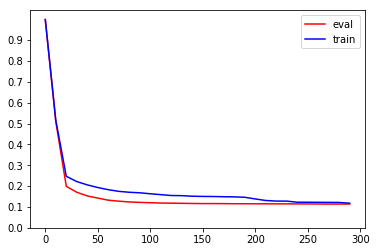

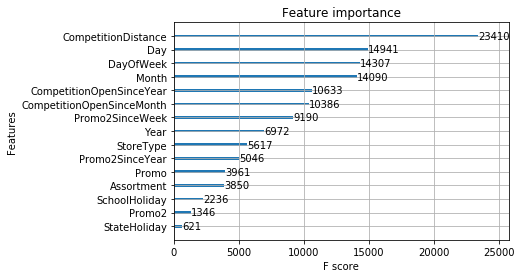

In [74]:
#从最终的训练importnace中看果然是时间序列影响比较大
evaldata = ret['eval']['rmspe'][0:num_trees:10]
traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,num_trees,10),evaldata,color='red',label="eval")
plt.plot(range(0,num_trees,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()
xgb.plot_importance(gbm2)

In [75]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm2.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [76]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)